# Spontaneous emission and coherent drive

In [1]:
#Qutip
from qutip import *
from qutip.piqs import *

#from collections import namedtuple

#Scipy
import scipy as sp
import scipy.integrate as integrate
import scipy.special as special
import scipy.sparse as spr
from scipy.sparse.linalg import eigs
from scipy.integrate import quad, dblquad

#Matplotlib
import matplotlib as mpl
from matplotlib import cm
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

#For latex fonts in the plots
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
#plt.style.use('ggplot')


#Math
import csv
import numpy as np
import math as mt

#For doing an animation of the Bloch sphere
from pylab import *
import matplotlib.animation as animation
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

#Bonus
import itertools as itr
from tqdm import tqdm_notebook
import time
import imageio

## Function definitions

In [2]:
def complex_quadrature(func, a, b, **kwargs):
    def real_func(x):
        return np.real(func(x))
    def imag_func(x):
        return np.imag(func(x))
    real_integral = quad(real_func, a, b, **kwargs)
    imag_integral = quad(imag_func, a, b, **kwargs)
    return (real_integral[0] + 1j*imag_integral[0], real_integral[1:], imag_integral[1:])

## 1) Spontaneous emission - no spin

\begin{equation}
\left|\Psi(0)\right\rangle =C_{g}\left|g,0\right\rangle +C_{e}\left|e,0\right\rangle 
\end{equation}

\begin{equation}
\left|\Psi(t_{N})\right\rangle =\;C_{g}\left|g,0\right\rangle +C_{e}\left[e^{-\frac{\gamma t_{N}}{2}}\left|e,0\right\rangle -\sqrt{\gamma\Delta t}\sum_{j=0}^{N-1}e^{-i\omega_{0}t_{j}}\left|g,1_{j}\right\rangle \right].
\end{equation}
 

Computing the output field, using $C_{g}=\cos\left(\theta/2\right),C_{e}=\sin\left(\theta/2\right)$

\begin{align}
\langle b_{\text{out}}\rangle & =\left\langle \Psi(t_{N})\right|b_{\text{out}}\left|\Psi(t_{N})\right\rangle \\
 & =-\sqrt{\gamma}\sin\left(\frac{\theta}{2}\right)\cos\left(\frac{\theta}{2}\right)e^{-\frac{\gamma t_{N}}{2}}e^{-i\omega_{0}t_{N}}
\end{align}
 Computing the mean of $\sigma$, in the interaction picture

\begin{align}
\langle\sigma(t_{N})\rangle & =e^{-i\omega_{0}t_{N}}\left\langle \Psi(t_{N})\right|\sigma(t_{N})\left|\Psi(t_{N})\right\rangle \\
 & =e^{-i\omega_{0}t_{N}}\sin\left(\frac{\theta}{2}\right)\cos\left(\frac{\theta}{2}\right)e^{-\frac{\gamma t_{N}}{2}}
\end{align}
 Hence, they are related by,

\begin{equation}
\langle b_{\text{out}}(t_{N})\rangle=-\sqrt{\gamma}\langle\sigma(t_{N})\rangle
\end{equation}

In [3]:
#Parameters
Omega = 1.0
delta_omega = 0.5*Omega
Gamma_pd = 0.0*Omega
Gamma_1 = 0.1*Omega
gamma = Gamma_1

sm = sigmam()
sp = sigmap()
#H_nhSE = (delta_omega-1j*gamma*0.5)*sp*sm
H_SE = (delta_omega)*sp*sm

t_range = np.linspace(0,8*(2+1/8)*np.pi,4*101)
discrete_t_range = np.arange(0,8*(2+1/8)*np.pi,4*np.pi*(1/8))

#Intial state
coherence_angle = np.pi/2
psi_0 = np.cos(coherence_angle/2)*ket('1')+np.sin(coherence_angle/2)*ket('0')


#In the following we'll append the relevant operators depending on the parameters
c_ops = [] 

# qubit dissipation
rate = gamma
if rate > 0.0:
    c_ops.append(np.sqrt(rate)*sm)

    
# Relevant expectation values list
expec_list = [sp*sm , sm*sp , sm, sigmax(),sigmay(),sigmaz()]

result = mesolve(H_SE, psi_0, t_range, c_ops, expec_list)

In [4]:
omega_0 = delta_omega
def Pe_SE(t):
    return np.sin(coherence_angle/2)**2*np.exp(-gamma*t)

def mean_sigmaSE(t):
    value = np.exp(-1j*omega_0*t)*np.sin(coherence_angle/2)*np.cos(coherence_angle/2)*np.exp(-gamma*0.5*t)
    return np.real(value)

In [5]:
discrete_PeSE = []
discrete_cohSE = []

for i in discrete_t_range:
    np.array([discrete_PeSE.append(Pe_SE(i))])
    np.array([discrete_cohSE.append(mean_sigmaSE(i))])

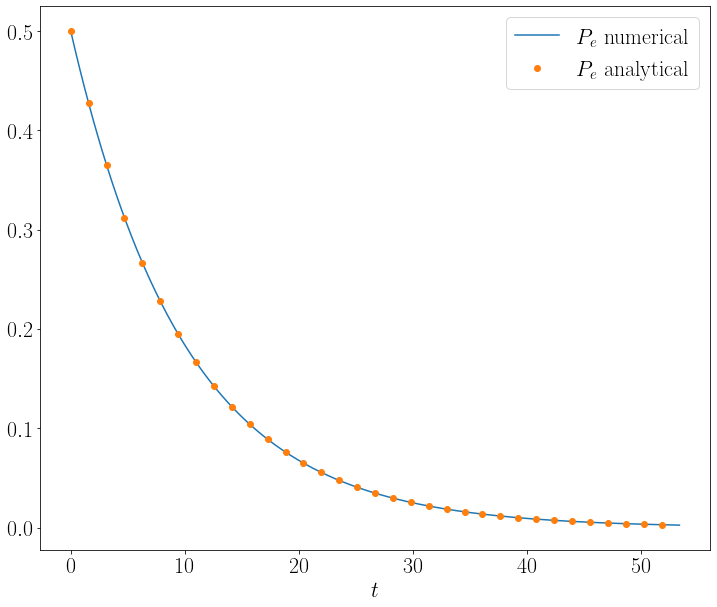

In [6]:
P_exc = result.expect[0]
P_gs = result.expect[1]
Coh = result.expect[2]

fig, axs = plt.subplots(1,1, figsize = (12,10))

plt.rc('text', usetex=True)
plt.rc('font', family='serif')

axs.plot(t_range, P_exc,  label = r"$P_e$ numerical")
axs.plot(discrete_t_range, discrete_PeSE, 'o', label = r"$P_e$ analytical")
#axs.plot(t_range, P_gs, label = r"$P_g=\langle \sigma \sigma^\dagger \rangle$")
#axs.plot(t_range, np.real(Coh), label = r"$\Re\{\langle \sigma \rangle \}$ numerical")
#axs.plot(discrete_t_range, discrete_cohSE, 'o', label = r"$\Re\{\langle \sigma \rangle \}$ analytical")
axs.legend(fontsize = 22)
axs.tick_params(axis='x', labelsize=22)#These lines set the font size of the xy labels
axs.tick_params(axis='y', labelsize=22)
axs.set_xlabel(r'$t$', size = 22)
#axs.set_ylabel(r'$\langle\sigma^\dagger \sigma\rangle$', size = 22)
#axs.set_title('Comparison CM vs. numerical solution', size = 22)

plt.savefig('Comparison-num-vs-analy-Res-Spontaneous-E-no-spin.png',bbox_inches='tight') #Save sempre antes do show!
plt.show()

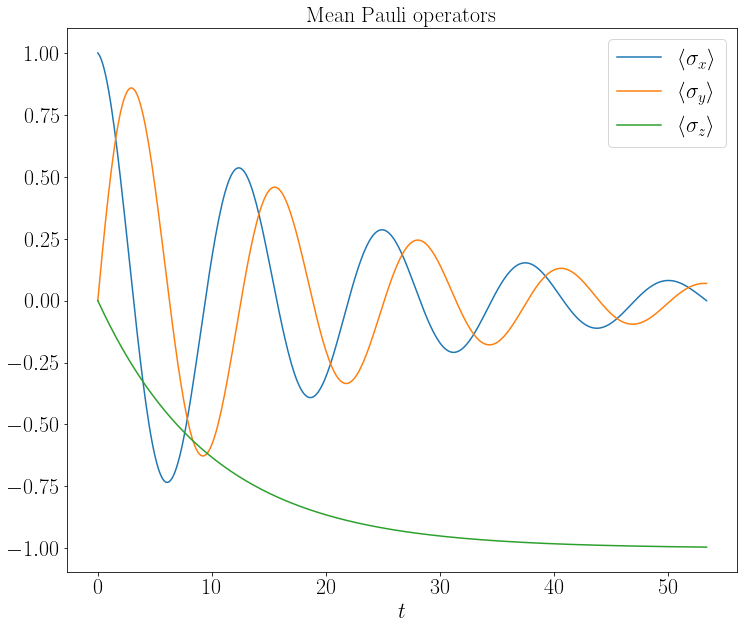

In [7]:
mean_Sx = result.expect[3]
mean_Sy = result.expect[4]
mean_Sz = result.expect[5]

fig, axs = plt.subplots(1,1, figsize = (12,10))

plt.rc('text', usetex=True)
plt.rc('font', family='serif')

axs.plot(t_range, mean_Sx, label = r"$\langle \sigma_x \rangle$")
axs.plot(t_range, mean_Sy,  label = r"$\langle \sigma_y \rangle$")
axs.plot(t_range, mean_Sz,  label = r"$\langle \sigma_z \rangle$")
axs.legend(fontsize = 22)
axs.tick_params(axis='x', labelsize=22)#These lines set the font size of the xy labels
axs.tick_params(axis='y', labelsize=22)
axs.set_xlabel(r'$t$', size = 22)
#axs.set_ylabel(r'$\langle\sigma^\dagger \sigma\rangle$', size = 22)
axs.set_title(r'Mean Pauli operators', size = 22)

plt.savefig('Mean-Pauli-ops-Res-Spontaneous-E-no-spin.png',bbox_inches='tight') #Save sempre antes do show!
plt.show()

<ipython-input-8-84b388531fdc>:11: RuntimeWarning: divide by zero encountered in double_scalars
  phi_vec.append(np.arctan(j/mean_Sy[i]))


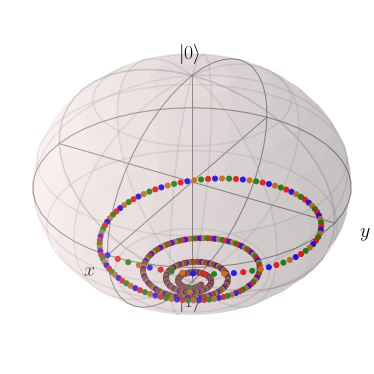

In [8]:
theta_vec = []
phi_vec = []

for i in mean_Sz:
    theta_vec.append(np.arccos(i))
    
for i,j in enumerate(mean_Sx):
    if j == 0:
        phi_vec.append(np.pi/2)
    else:
        phi_vec.append(np.arctan(j/mean_Sy[i]))

xx = mean_Sx
yy = mean_Sy
zz = mean_Sz

b = Bloch()
b.add_points([xx,yy,zz],'m')
b.show()

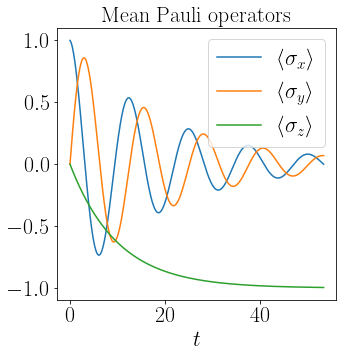

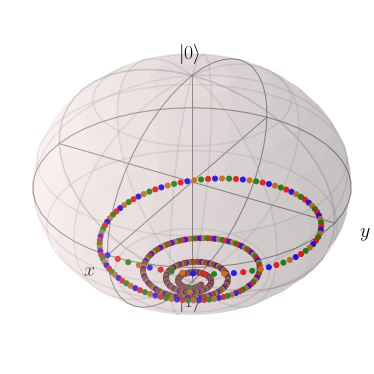

In [9]:
mean_Sx = result.expect[3]
mean_Sy = result.expect[4]
mean_Sz = result.expect[5]

fig, axs = plt.subplots(1,1, figsize = (5,5))

plt.rc('text', usetex=True)
plt.rc('font', family='serif')

axs.plot(t_range, mean_Sx, label = r"$\langle \sigma_x \rangle$")
axs.plot(t_range, mean_Sy,  label = r"$\langle \sigma_y \rangle$")
axs.plot(t_range, mean_Sz,  label = r"$\langle \sigma_z \rangle$")
axs.legend(fontsize = 22)
axs.tick_params(axis='x', labelsize=22)#These lines set the font size of the xy labels
axs.tick_params(axis='y', labelsize=22)
axs.set_xlabel(r'$t$', size = 22)
#axs.set_ylabel(r'$\langle\sigma^\dagger \sigma\rangle$', size = 22)
axs.set_title(r'Mean Pauli operators', size = 22)

plt.show()
b.show()

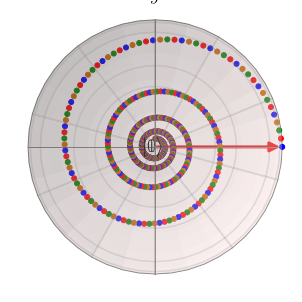

<Figure size 360x360 with 0 Axes>

In [10]:
fig = figure()
ax = Axes3D(fig,azim = 180, elev = -270)
sphere = Bloch(axes = ax)

def animate(i):
     sphere.clear()
     sphere.add_vectors([1,0,0])
     sphere.add_points([mean_Sx.tolist()[0:i+1],mean_Sy.tolist()[0:i+1],mean_Sz.tolist()[0:i+1]],'m')
     sphere.make_sphere()
     return ax

def init():
     sphere.vector_color = ['r']
     return ax

ani = animation.FuncAnimation(fig, animate, len(mean_Sx), init_func=init,repeat=False)
ani.save('blochXY-SE-no-spin.gif',writer='PillowWriter',fps = 21)
plt.show()

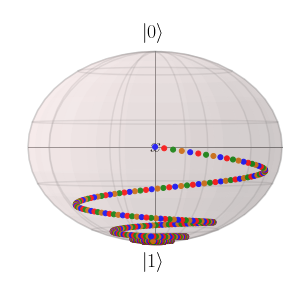

<Figure size 360x360 with 0 Axes>

In [11]:
fig = figure()
ax = Axes3D(fig,azim = -90, elev = 0)
sphere = Bloch(axes = ax)

def animate(i):
     sphere.clear()
     sphere.add_vectors([1,0,0])
     sphere.add_points([mean_Sx.tolist()[0:i+1],mean_Sy.tolist()[0:i+1],mean_Sz.tolist()[0:i+1]],'m')
     sphere.make_sphere()
     return ax

def init():
     sphere.vector_color = ['r']
     return ax

ani = animation.FuncAnimation(fig, animate, len(mean_Sx), init_func=init,repeat=False)
ani.save('blochZ-SE-no-spin.gif',writer='PillowWriter',fps = 21)
plt.show()

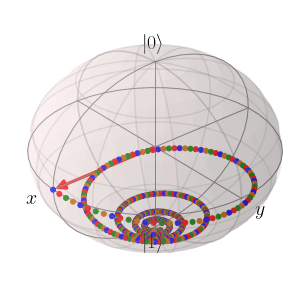

<Figure size 360x360 with 0 Axes>

In [12]:
fig = figure()
ax = Axes3D(fig,azim = -40, elev = 30)
sphere = Bloch(axes = ax)

def animate(i):
     sphere.clear()
     sphere.add_vectors([1,0,0])
     sphere.add_points([mean_Sx.tolist()[0:i+1],mean_Sy.tolist()[0:i+1],mean_Sz.tolist()[0:i+1]],'m')
     sphere.make_sphere()
     return ax

def init():
     sphere.vector_color = ['r']
     return ax

ani = animation.FuncAnimation(fig, animate, len(mean_Sx), init_func=init,repeat=False)
ani.save('blochXYZ-SE-no-spin.gif',writer='PillowWriter',fps = 21)
plt.show()

## 2) Spontaneous emisson - with spin

In [13]:
#Parameters
Omega = 1.0
delta_omega_L = 0.6*Omega
delta_omega_R = 0.5*Omega
Gamma_pd_L = 0.0*Omega
Gamma_pd_R = 0.0*Omega
gamma_L = 0.0*Omega
gamma_R = 0.01*Omega

#Defining left and right spin operators 
sigma_R = tensor(ket('1'),ket('0'))*tensor(bra('0'),bra('0'))
sigma_L = tensor(ket('1'),ket('1'))*tensor(bra('0'),bra('1'))
sigma_Rd = sigma_R.dag()
sigma_Ld = sigma_L.dag()

#These operators act only on the atom state
sigma_x_at = tensor(sigmax(),qeye(2))
sigma_y_at = tensor(sigmay(),qeye(2))
sigma_z_at = tensor(sigmaz(),qeye(2))

#These operators act only on the spin state
sigma_x_spin = tensor(qeye(2),sigmax())
sigma_y_spin = tensor(qeye(2),sigmay())
sigma_z_spin = tensor(qeye(2),sigmaz())

#These operators seem to be unuseful
# sigma_xR = (sigma_Rd + sigma_R)/2
# sigma_yR = (sigma_Rd - sigma_R)/2*1j
# sigma_zR = tensor(ket('0'),ket('0'))*tensor(bra('0'),bra('0'))-tensor(ket('1'),ket('0'))*tensor(bra('1'),bra('0'))

# sigma_xL = (sigma_Ld + sigma_L)/2
# sigma_yL = (sigma_Ld - sigma_L)/2*1j
# sigma_zL = tensor(ket('0'),ket('1'))*tensor(bra('0'),bra('1'))-tensor(ket('1'),ket('1'))*tensor(bra('1'),bra('1'))



#H_nhSE = (delta_omega-1j*gamma*0.5)*sp*sm
H_SErl = (delta_omega_L)*sigma_Ld*sigma_L + (delta_omega_R)*sigma_Rd*sigma_R

t_range = np.linspace(0,8*(2+1/8)*np.pi,4*101)
discrete_t_range = np.arange(0,8*(2+1/8)*np.pi,4*np.pi*(1/8))

#Intial state
coherence_angle = np.pi/2
psi_0rl = np.cos(coherence_angle/2)*tensor(ket('0'),ket('1')) + np.sin(coherence_angle/2)*tensor(ket('0'),ket('0'))


#In the following we'll append the relevant operators depending on the parameters
c_ops = [] 

# qubit dissipation for each polarization
rate_L = gamma_L
if rate_L > 0.0:
    c_ops.append(np.sqrt(rate_L)*sigma_L)
    
rate_R = gamma_R
if rate_R > 0.0:
    c_ops.append(np.sqrt(rate_R)*sigma_R)

    
# Relevant expectation values list 0-7
expec_list = [sigma_Rd*sigma_R, sigma_Ld*sigma_L, 
              sigma_x_at, sigma_y_at, sigma_z_at,
              sigma_x_spin, sigma_y_spin, sigma_z_spin]

result = mesolve(H_SErl, psi_0rl, t_range, c_ops, expec_list)

In [14]:
omega_0 = delta_omega
aaaa  

In [15]:
discrete_PeSE_Tot = []
#discrete_cohSE = []

for i in discrete_t_range:
    np.array([discrete_PeSE_Tot.append(Pe_SE_Tot(i))])
    #np.array([discrete_cohSE.append(mean_sigmaSE(i))])

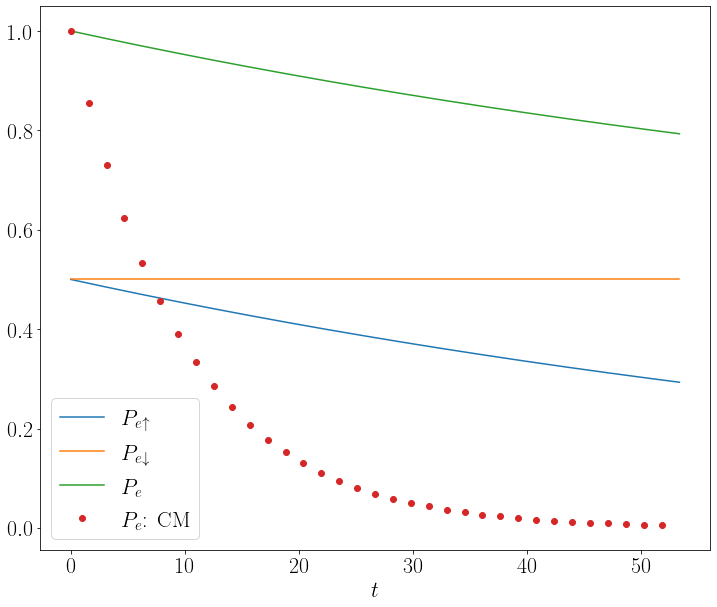

In [16]:
mean_sigmaRdsigmaR = result.expect[0]
mean_sigmaLdsigmaL = result.expect[1]
#Coh = result.expect[2]

fig, axs = plt.subplots(1,1, figsize = (12,10))

plt.rc('text', usetex=True)
plt.rc('font', family='serif')

axs.plot(t_range, mean_sigmaRdsigmaR,  label = r"$P_{e\uparrow}$")
axs.plot(t_range, mean_sigmaLdsigmaL,  label = r"$P_{e\downarrow}$")
axs.plot(t_range, mean_sigmaLdsigmaL + mean_sigmaRdsigmaR,  label = r"$P_e$")
axs.plot(discrete_t_range, discrete_PeSE_Tot, 'o', label = r"$P_e$: CM")
#axs.plot(t_range, P_gs, label = r"$P_g=\langle \sigma \sigma^\dagger \rangle$")
#axs.plot(t_range, np.real(Coh), label = r"$\Re\{\langle \sigma \rangle \}$ numerical")
#axs.plot(discrete_t_range, discrete_cohSE, 'o', label = r"$\Re\{\langle \sigma \rangle \}$ analytical")
axs.legend(fontsize = 22)
axs.tick_params(axis='x', labelsize=22)#These lines set the font size of the xy labels
axs.tick_params(axis='y', labelsize=22)
axs.set_xlabel(r'$t$', size = 22)
#axs.set_ylabel(r'$\langle\sigma^\dagger \sigma\rangle$', size = 22)
#axs.set_title('Comparison CM vs. numerical solution', size = 22)

plt.savefig('Comparison-num-vs-analy-Res-Spontaneous-E-with-spin.png',bbox_inches='tight') #Save sempre antes do show!
plt.show()

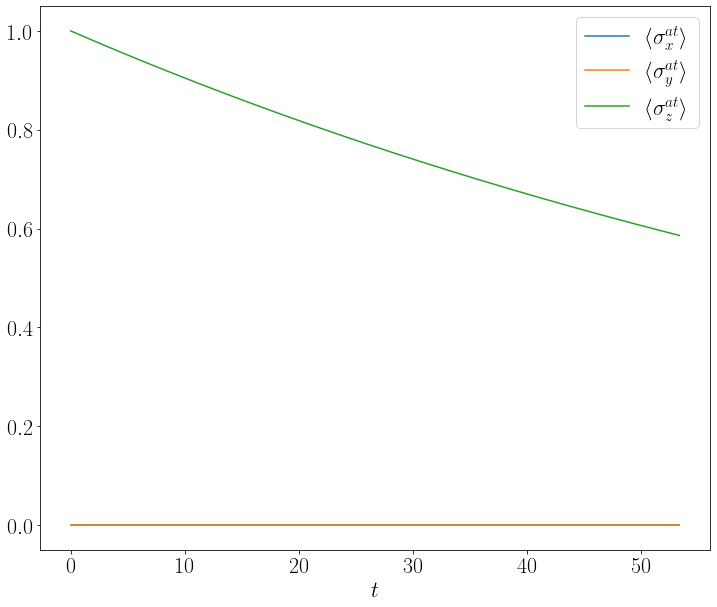

In [17]:
mean_sigmaxat = result.expect[2]
mean_sigmayat = result.expect[3]
mean_sigmazat = result.expect[4]


fig, axs = plt.subplots(1,1, figsize = (12,10))

plt.rc('text', usetex=True)
plt.rc('font', family='serif')

axs.plot(t_range, mean_sigmaxat,  label = r"$\langle\sigma_x^{at}\rangle$")
axs.plot(t_range, mean_sigmayat,  label = r"$\langle\sigma_y^{at}\rangle$")
axs.plot(t_range, mean_sigmazat,  label = r"$\langle\sigma_z^{at}\rangle$")
#axs.plot(discrete_t_range, discrete_PeSE, 'o', label = r"$P_e$ analytical")
#axs.plot(t_range, P_gs, label = r"$P_g=\langle \sigma \sigma^\dagger \rangle$")
#axs.plot(t_range, np.real(Coh), label = r"$\Re\{\langle \sigma \rangle \}$ numerical")
#axs.plot(discrete_t_range, discrete_cohSE, 'o', label = r"$\Re\{\langle \sigma \rangle \}$ analytical")
axs.legend(fontsize = 22)
axs.tick_params(axis='x', labelsize=22)#These lines set the font size of the xy labels
axs.tick_params(axis='y', labelsize=22)
axs.set_xlabel(r'$t$', size = 22)
#axs.set_ylabel(r'$\langle\sigma^\dagger \sigma\rangle$', size = 22)
#axs.set_title('Comparison CM vs. numerical solution', size = 22)

plt.savefig('Comparison-num-vs-analy-Res-Spontaneous-E-with-spin-at.png',bbox_inches='tight') #Save sempre antes do show!
plt.show()

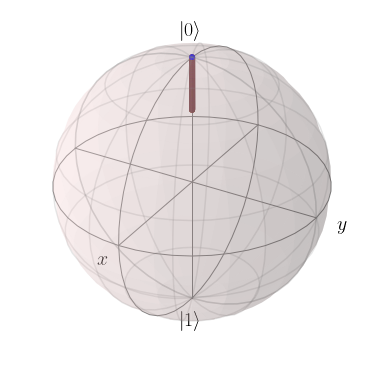

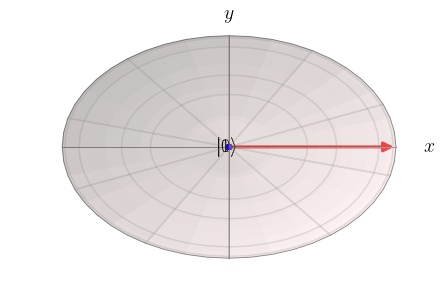

<Figure size 360x360 with 0 Axes>

In [18]:
xx = mean_sigmaxat
yy = mean_sigmayat
zz = mean_sigmazat

b = Bloch()
b.add_points([xx,yy,zz],'m')
b.show()

fig = figure()
ax = Axes3D(fig,azim = 180, elev = -270)
sphere = Bloch(axes = ax)

def animate(i):
     sphere.clear()
     sphere.add_vectors([1,0,0])
     sphere.add_points([mean_sigmaxat.tolist()[0:i+1],mean_sigmayat.tolist()[0:i+1],mean_sigmazat.tolist()[0:i+1]],'m')
     sphere.make_sphere()
     return ax

def init():
     sphere.vector_color = ['r']
     return ax

ani = animation.FuncAnimation(fig, animate, len(mean_sigmaxat), init_func=init,repeat=False)
ani.save('blochXY-SE-spin-at.gif',writer='PillowWriter',fps = 21)
plt.show()

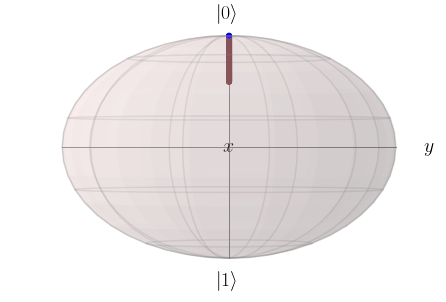

<Figure size 360x360 with 0 Axes>

In [19]:
fig = figure()
ax = Axes3D(fig,azim = -90, elev = 0)
sphere = Bloch(axes = ax)

def animate(i):
     sphere.clear()
     sphere.add_vectors([1,0,0])
     sphere.add_points([mean_sigmaxat.tolist()[0:i+1],mean_sigmayat.tolist()[0:i+1],mean_sigmazat.tolist()[0:i+1]],'m')
     sphere.make_sphere()
     return ax

def init():
     sphere.vector_color = ['r']
     return ax

ani = animation.FuncAnimation(fig, animate, len(mean_sigmaxat), init_func=init,repeat=False)
ani.save('blochZ-SE-spin-at.gif',writer='PillowWriter',fps = 21)
plt.show()

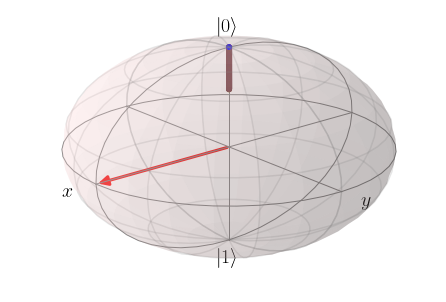

<Figure size 360x360 with 0 Axes>

In [20]:
fig = figure()
ax = Axes3D(fig,azim = -40, elev = 30)
sphere = Bloch(axes = ax)

def animate(i):
     sphere.clear()
     sphere.add_vectors([1,0,0])
     sphere.add_points([mean_sigmaxat.tolist()[0:i+1],mean_sigmayat.tolist()[0:i+1],mean_sigmazat.tolist()[0:i+1]],'m')
     sphere.make_sphere()
     return ax

def init():
     sphere.vector_color = ['r']
     return ax

ani = animation.FuncAnimation(fig, animate, len(mean_sigmaxat), init_func=init,repeat=False)
ani.save('blochXYZ-SE-spin-at.gif',writer='PillowWriter',fps = 21)
plt.show()

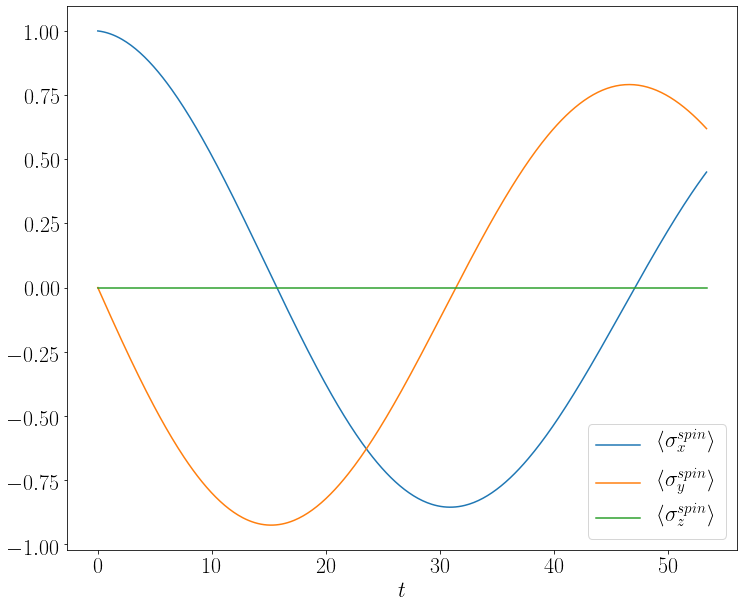

In [21]:
mean_sigmax_spin = result.expect[5]
mean_sigmay_spin = result.expect[6]
mean_sigmaz_spin = result.expect[7]


fig, axs = plt.subplots(1,1, figsize = (12,10))

axs.plot(t_range, mean_sigmax_spin,  label = r"$\langle\sigma_x^{spin}\rangle$")
axs.plot(t_range, mean_sigmay_spin,  label = r"$\langle\sigma_y^{spin}\rangle$")
axs.plot(t_range, mean_sigmaz_spin,  label = r"$\langle\sigma_z^{spin}\rangle$")
#axs.plot(discrete_t_range, discrete_PeSE, 'o', label = r"$P_e$ analytical")
#axs.plot(t_range, P_gs, label = r"$P_g=\langle \sigma \sigma^\dagger \rangle$")
#axs.plot(t_range, np.real(Coh), label = r"$\Re\{\langle \sigma \rangle \}$ numerical")
#axs.plot(discrete_t_range, discrete_cohSE, 'o', label = r"$\Re\{\langle \sigma \rangle \}$ analytical")
axs.legend(fontsize = 22)
axs.tick_params(axis='x', labelsize=22)#These lines set the font size of the xy labels
axs.tick_params(axis='y', labelsize=22)
axs.set_xlabel(r'$t$', size = 22)
#axs.set_ylabel(r'$\langle\sigma^\dagger \sigma\rangle$', size = 22)
#axs.set_title('Comparison CM vs. numerical solution', size = 22)

plt.savefig('Comparison-num-vs-analy-Res-Spontaneous-E-with-spin.png',bbox_inches='tight') #Save sempre antes do show!
plt.show()

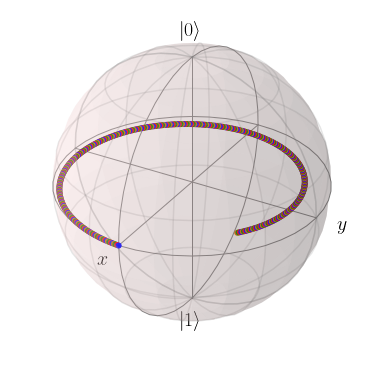

In [22]:
xx = mean_sigmax_spin
yy = mean_sigmay_spin
zz = mean_sigmaz_spin

b = Bloch()
b.add_points([xx,yy,zz],'m')
b.show()

NameError: name 'mean_sigmax_spin' is not defined

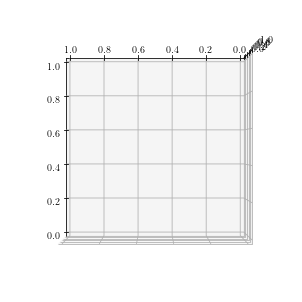

In [18]:
fig = figure()
ax = Axes3D(fig,azim = 180, elev = -270)
sphere = Bloch(axes = ax)

def animate(i):
     sphere.clear()
     sphere.add_vectors([1,0,0])
     sphere.add_points([mean_sigmax_spin.tolist()[0:i+1],mean_sigmay_spin.tolist()[0:i+1],mean_sigmaz_spin.tolist()[0:i+1]],'m')
     sphere.make_sphere()
     return ax

def init():
     sphere.vector_color = ['r']
     return ax

ani = animation.FuncAnimation(fig, animate, len(mean_sigmax_spin), init_func=init,repeat=False)
ani.save('blochXY-SE-spin.gif',writer='PillowWriter',fps = 21)
plt.show()

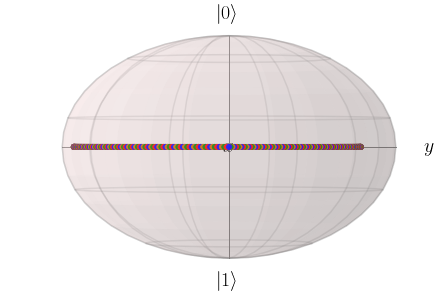

<Figure size 360x360 with 0 Axes>

In [24]:
fig = figure()
ax = Axes3D(fig,azim = -90, elev = 0)
sphere = Bloch(axes = ax)

def animate(i):
     sphere.clear()
     sphere.add_vectors([1,0,0])
     sphere.add_points([mean_sigmax_spin.tolist()[0:i+1],mean_sigmay_spin.tolist()[0:i+1],mean_sigmaz_spin.tolist()[0:i+1]],'m')
     sphere.make_sphere()
     return ax

def init():
     sphere.vector_color = ['r']
     return ax

ani = animation.FuncAnimation(fig, animate, len(mean_sigmax_spin), init_func=init,repeat=False)
ani.save('blochZ-SE-spin.gif',writer='PillowWriter',fps = 21)
plt.show()

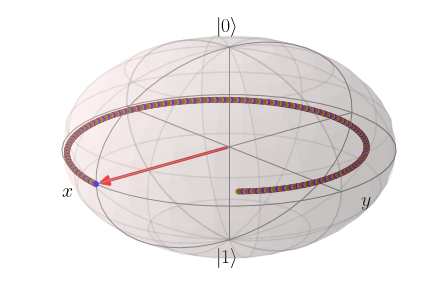

<Figure size 360x360 with 0 Axes>

In [25]:
fig = figure()
ax = Axes3D(fig,azim = -40, elev = 30)
sphere = Bloch(axes = ax)

def animate(i):
     sphere.clear()
     sphere.add_vectors([1,0,0])
     sphere.add_points([mean_sigmax_spin.tolist()[0:i+1],mean_sigmay_spin.tolist()[0:i+1],mean_sigmaz_spin.tolist()[0:i+1]],'m')
     sphere.make_sphere()
     return ax

def init():
     sphere.vector_color = ['r']
     return ax

ani = animation.FuncAnimation(fig, animate, len(mean_sigmax_spin), init_func=init,repeat=False)
ani.save('blochXYZ-SE-spin.gif',writer='PillowWriter',fps = 21)
plt.show()

## 3) Resonant coherent drive - no spin

In [19]:
#Parameters
Omega = 1.0
delta_omega = 0.5*Omega
Gamma_pd = 0.0*Omega
Gamma_1 = 0.1*Omega
gamma = Gamma_1

In [20]:
#Non-hermitian Hamiltonian for the atom
sm = sigmam()
sp = sigmap()
H_nh = delta_omega*sp*sm - 0.5*Omega*sigmay()

t_range = np.linspace(0,(2+1/8)*np.pi,101)
discrete_t_range = np.arange(0,(2+1/8)*np.pi,np.pi*(1/8))

#Intial state
psi_0 = ket('1')


#In the following we'll append the relevant operators depending on the parameters
c_ops = [] 

# qubit dissipation
rate = gamma
if rate > 0.0:
    c_ops.append(np.sqrt(rate)*sm)

    
# Relevant expectation values list
expec_list = [sp*sm , sm*sp , sm, sigmax(),sigmay(),sigmaz()]

In [21]:
%%time 
result = mesolve(H_nh, psi_0, t_range, c_ops, expec_list)

CPU times: user 9.69 ms, sys: 1.64 ms, total: 11.3 ms
Wall time: 9.96 ms


#### Analytical solution

In [24]:
Omega_R = ((0.5*Omega)**2 + (0.5*delta_omega - 1j*0.25*gamma)**2)**0.5

#Defining the coefficients
def f0g(t):
    function = (np.e**(-0.25*gamma*t)*(4*Omega_R*np.cos(Omega_R*t)+(gamma + 1j*2*delta_omega)*np.sin(Omega_R*t)))/(4*Omega_R)
    return function

def f0e(t):
    function = (np.e**(-0.25*gamma*t)*Omega*np.sin(Omega_R*t))/(2*Omega_R)
    return function

def f1g(t,tau): #tau is the integration variable
    f = gamma**0.5*((np.e**(-0.25*gamma*t)*Omega)/(8*Omega_R**2))*np.sin(Omega_R*tau)*(4*Omega_R*np.cos(Omega_R*(t-tau))+(gamma+1j*2*delta_omega*np.sin(Omega_R*(t-tau))))
    return f

def f1e(t,tau): #tau is the integration variable
    f = gamma**0.5*np.e**(-0.25*gamma*t)*(Omega/(2*Omega_R))**2*np.sin(Omega_R*(t-tau))*np.sin(Omega_R*tau)
    return f

def P_e(t):
    Int = integrate.quad(lambda tau: np.abs(f1e(t,tau))**2,0,t)
    pe = np.abs(f0e(t))**2 + Int[0] #I have to use [0] because this is the value of the integral [1] is the error of the numerical computation (see doc. https://docs.scipy.org/doc/scipy/reference/tutorial/integrate.html)
    return pe

def mean_sigma(t):
    Int2 = complex_quadrature(lambda tau: f1e(t,tau)*np.conj(f1g(t,tau)),0,t)
    return f0e(t)*np.conj(f0g(t)) + Int2[0]
    

In [25]:
mean_sigma(2*np.pi/8)

(0.3383101205082117-0.07046633877108179j)

In [26]:
P_e(np.pi/8)

0.037203247116008586

In [30]:
discrete_Pe = np.array([P_e(i) for i in discrete_t_range])
discrete_coh = np.array([np.real(mean_sigma(i)) for i in discrete_t_range])

#for i in discrete_t_range:
#    np.array([discrete_Pe.append(P_e(i))])
#    np.array([discrete_coh.append(mean_sigma(i))])

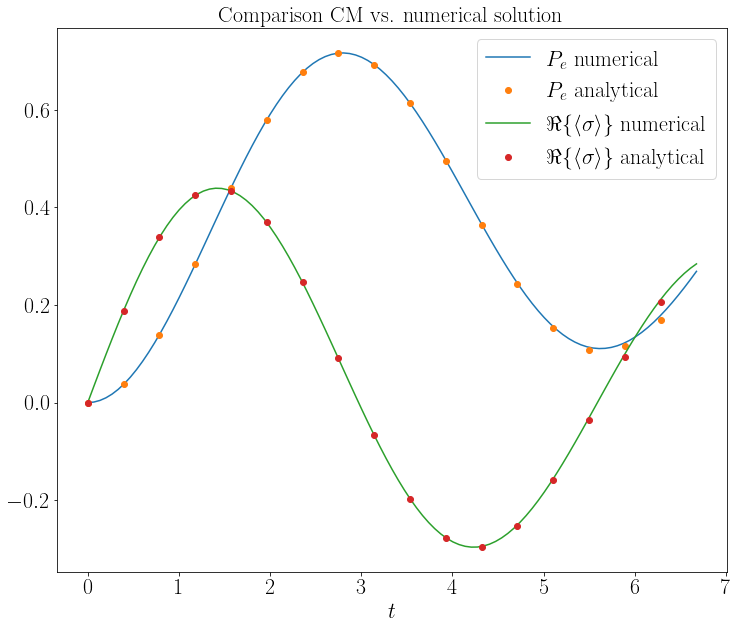

In [31]:
P_exc = result.expect[0]
P_gs = result.expect[1]
Coh = result.expect[2]

fig, axs = plt.subplots(1,1, figsize = (12,10))

axs.plot(t_range, P_exc,  label = r"$P_e$ numerical")
axs.plot(discrete_t_range, discrete_Pe, 'o', label = r"$P_e$ analytical")
#axs.plot(t_range, P_gs, label = r"$P_g=\langle \sigma \sigma^\dagger \rangle$")
axs.plot(t_range, np.real(Coh), label = r"$\Re\{\langle \sigma \rangle \}$ numerical")
axs.plot(discrete_t_range, discrete_coh, 'o', label = r"$\Re\{\langle \sigma \rangle \}$ analytical")
axs.legend(fontsize = 22)
axs.tick_params(axis='x', labelsize=22)#These lines set the font size of the xy labels
axs.tick_params(axis='y', labelsize=22)
axs.set_xlabel(r'$t$', size = 22)
#axs.set_ylabel(r'$\langle\sigma^\dagger \sigma\rangle$', size = 22)
axs.set_title('Comparison CM vs. numerical solution', size = 22)

plt.savefig('Comparison-num-vs-analy-Res-Cohe-drive-no-spin.png',bbox_inches='tight') #Save sempre antes do show!
plt.show()

#### Bloch sphere visualization

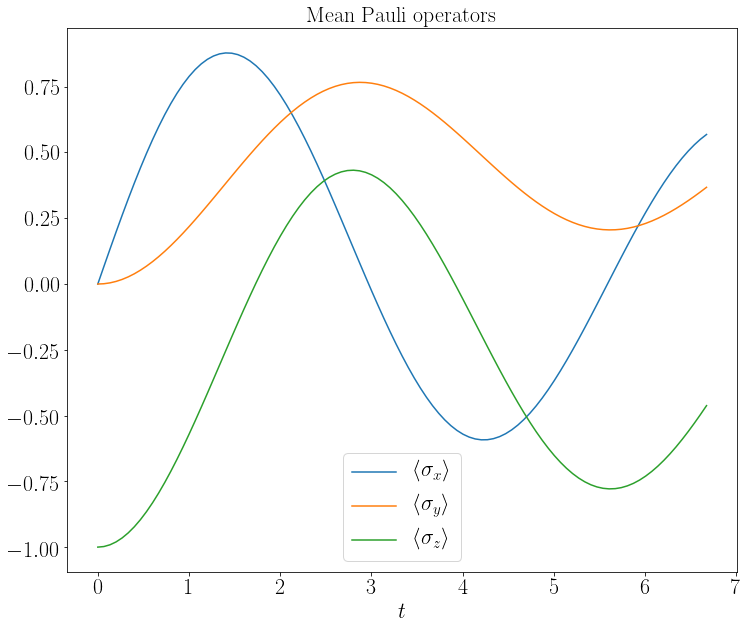

In [34]:
mean_Sx = result.expect[3]
mean_Sy = result.expect[4]
mean_Sz = result.expect[5]

fig, axs = plt.subplots(1,1, figsize = (12,10))

plt.rc('text', usetex=True)
plt.rc('font', family='serif')

axs.plot(t_range, mean_Sx, label = r"$\langle \sigma_x \rangle$")
axs.plot(t_range, mean_Sy,  label = r"$\langle \sigma_y \rangle$")
axs.plot(t_range, mean_Sz,  label = r"$\langle \sigma_z \rangle$")
axs.legend(fontsize = 22)
axs.tick_params(axis='x', labelsize=22)#These lines set the font size of the xy labels
axs.tick_params(axis='y', labelsize=22)
axs.set_xlabel(r'$t$', size = 22)
#axs.set_ylabel(r'$\langle\sigma^\dagger \sigma\rangle$', size = 22)
axs.set_title(r'Mean Pauli operators', size = 22)

plt.savefig('Mean-Pauli-ops-Res-Cohe-drive-no-spin.png',bbox_inches='tight') #Save sempre antes do show!
plt.show()

In [35]:
theta_vec = []
phi_vec = []

for i in mean_Sz:
    theta_vec.append(np.arccos(i))
    
for i,j in enumerate(mean_Sx):
    if j == 0:
        phi_vec.append(np.pi/2)
    else:
        phi_vec.append(np.arctan(j/mean_Sy[i]))

In [36]:
xx = mean_Sx#[np.sin(theta_vec[i])*np.cos(phi_vec[i]) for i in np.arange(0,len(theta_vec))]
yy = mean_Sy#[np.sin(theta_vec[i])*np.sin(phi_vec[i]) for i in np.arange(0,len(theta_vec))]
zz = mean_Sz

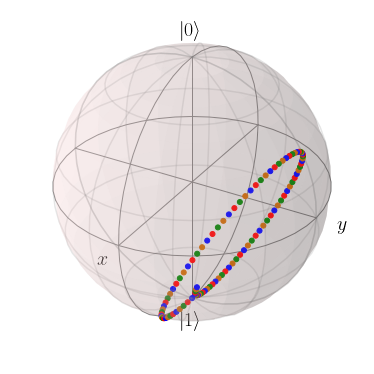

In [37]:
b = Bloch()
b.add_points([xx,yy,zz],'m')
b.show()

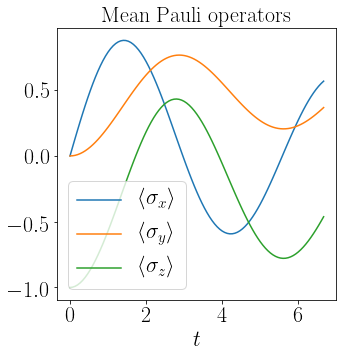

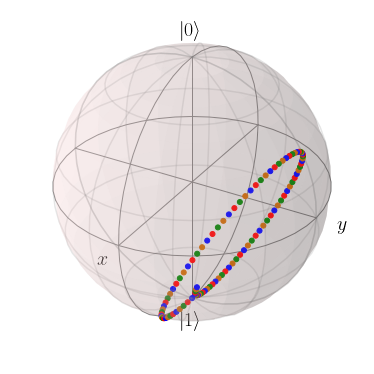

In [38]:
mean_Sx = result.expect[3]
mean_Sy = result.expect[4]
mean_Sz = result.expect[5]

fig, axs = plt.subplots(1,1, figsize = (5,5))

plt.rc('text', usetex=True)
plt.rc('font', family='serif')

axs.plot(t_range, mean_Sx, label = r"$\langle \sigma_x \rangle$")
axs.plot(t_range, mean_Sy,  label = r"$\langle \sigma_y \rangle$")
axs.plot(t_range, mean_Sz,  label = r"$\langle \sigma_z \rangle$")
axs.legend(fontsize = 22)
axs.tick_params(axis='x', labelsize=22)#These lines set the font size of the xy labels
axs.tick_params(axis='y', labelsize=22)
axs.set_xlabel(r'$t$', size = 22)
#axs.set_ylabel(r'$\langle\sigma^\dagger \sigma\rangle$', size = 22)
axs.set_title(r'Mean Pauli operators', size = 22)

plt.show()
b.show()

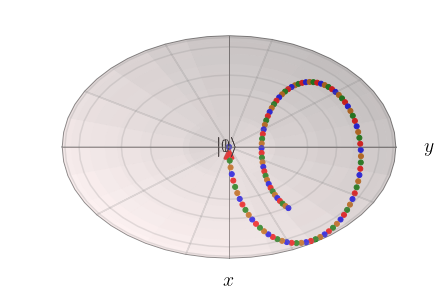

<Figure size 360x360 with 0 Axes>

In [39]:
fig = figure()
ax = Axes3D(fig,azim = -90, elev = -270)
sphere = Bloch(axes = ax)

def animate(i):
     sphere.clear()
     sphere.add_vectors([0,0,-1])
     sphere.add_points([mean_Sx.tolist()[0:i+1],mean_Sy.tolist()[0:i+1],mean_Sz.tolist()[0:i+1]],'m')
     sphere.make_sphere()
     return ax

def init():
     sphere.vector_color = ['r']
     return ax

ani = animation.FuncAnimation(fig, animate, len(mean_Sx), init_func=init,repeat=False)
ani.save('blochXY-Cohe-drive-no-spin.gif',writer='PillowWriter',fps = 21)
plt.show()

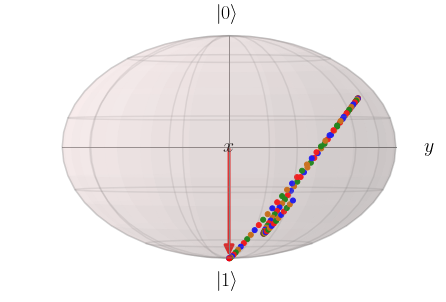

<Figure size 360x360 with 0 Axes>

In [40]:
fig = figure()
ax = Axes3D(fig,azim = -90, elev = 0)
sphere = Bloch(axes = ax)

def animate(i):
     sphere.clear()
     sphere.add_vectors([0,0,-1])
     sphere.add_points([mean_Sx.tolist()[0:i+1],mean_Sy.tolist()[0:i+1],mean_Sz.tolist()[0:i+1]],'m')
     sphere.make_sphere()
     return ax

def init():
     sphere.vector_color = ['r']
     return ax

ani = animation.FuncAnimation(fig, animate, len(mean_Sx), init_func=init,repeat=False)
ani.save('blochZ-Cohe-drive-no-spin.gif',writer='PillowWriter',fps = 21)
plt.show()

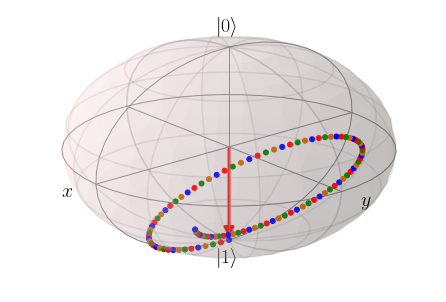

<Figure size 360x360 with 0 Axes>

In [41]:
fig = figure()
ax = Axes3D(fig,azim = -40, elev = 30)
sphere = Bloch(axes = ax)

def animate(i):
     sphere.clear()
     sphere.add_vectors([0,0,-1])
     sphere.add_points([mean_Sx.tolist()[0:i+1],mean_Sy.tolist()[0:i+1],mean_Sz.tolist()[0:i+1]],'m')
     sphere.make_sphere()
     return ax

def init():
     sphere.vector_color = ['r']
     return ax

ani = animation.FuncAnimation(fig, animate, len(mean_Sx), init_func=init,repeat=False)
ani.save('blochXYZ-Cohe-drive-no-spin.gif',writer='PillowWriter',fps = 21)
plt.show()

## 4) Resonant coherent drive - with spin

In [6]:
#################################
#    Defining spin operators 
#################################

# Left and Right
sigma_R = tensor(ket('1'),ket('0'))*tensor(bra('0'),bra('0')) # ok
sigma_L = tensor(ket('1'),ket('1'))*tensor(bra('0'),bra('1')) # ok
sigma_Rd = sigma_R.dag()
sigma_Ld = sigma_L.dag()

# Atomic
sigma_x_at = tensor(sigmax(),qeye(2)) # ok
sigma_y_at = tensor(sigmay(),qeye(2)) # ok
sigma_z_at = tensor(sigmaz(),qeye(2)) # ok

# Spin
sigma_x_spin = tensor(qeye(2),sigmax()) # ok
sigma_y_spin = tensor(qeye(2),sigmay()) # ok
sigma_z_spin = tensor(qeye(2),sigmaz()) # ok

In [7]:
# Hamiltonian coherent drive - ok
def H_coh_drive(detuning_L, detuning_R, Omega_L, Omega_R):
    H_L = detuning_L*sigma_Ld*sigma_L - 0.5*Omega_L*1j*(sigma_L - sigma_Ld)
    H_R = detuning_R*sigma_Rd*sigma_R - 0.5*Omega_R*1j*(sigma_R - sigma_Rd) 
    return H_L + H_R

# The function below SHOULD compute the L and R intensities
# def Intensities(mean_list_L,mean_list_R, gamma_L, gamma_R, amplitude_L, amplitude_R): #mean_list_i = [sigmaid*sigmai, sigma_i]
#     IL = gamma_L*mean_list_L[0] - gamma_L**0.5*(amplitude_L*np.conj(mean_list_L[1]) + amplitude_L*mean_list_L[1]) + np.abs(amplitude_L)**2
    
#     IR = gamma_R*mean_list_R[0] - gamma_R**0.5*(amplitude_R*np.conj(mean_list_R[1]) + amplitude_R*mean_list_R[1]) + np.abs(amplitude_R)**2
    
#     if mean_list_L[1] != 0:
#         bdR_bL = -gamma_L**0.5*alpha_L*np.conj(mean_list_L[1]) + alpha_L*alpha_R
#     else : 
#         bdR_bL = -gamma_R**0.5*alpha_R*np.conj(mean_list_L[1]) + alpha_L*alpha_R
    
#     IH = 0.5*(IL + IR + bdR_bL + np.conj(bdR_bL))
#     IV = 0.5*(IL + IR - (bdR_bL + np.conj(bdR_bL)))

#     ID = 0.5*(IL + IR + 1j*(bdR_bL - np.conj(bdR_bL)))
#     IA = 0.5*(IL + IR - 1j*(bdR_bL - np.conj(bdR_bL)))

#     return np.real(np.array([IL, IR, IH, IV, ID, IA]))

## Starting from $|g,\downarrow\rangle$ and $|e,\downarrow\rangle$

In [8]:
#################################
#      Parameters
#################################

Omega = 1.0

# Drive amplitude 
Omega_R = 0.0
Omega_L = Omega

# Dissipation
gamma_L = 0.01*Omega
gamma_R = 0.01*Omega

# Amplitudes - Horizontally polarized
alpha_L = 1/(2*gamma_L**0.5)
alpha_R = 1/(2*gamma_R**0.5)

# Pure dephasing - No pure dephasing considered
Gamma_pd_L = 0.0*Omega
Gamma_pd_R = 0.0*Omega

# Detunings - no detuning here
Delta_omega_L = 0*Omega_L
Delta_omega_R = 0*Omega_R

detuning_range = np.arange(-Omega, Omega + 0.5, 0.5) # 5 values

# Time range
t_range = np.linspace(0,2*np.pi,101) #time changes from 0 to 2Pi/Omega with steps of Pi/(4 Omega) 
discrete_t_range = np.arange(0,2*np.pi,np.pi*(1/8))

# In the following we'll append the relevant operators depending on the parameters
c_ops = [] 

# Qubit dissipation for each polarization
rate_L = gamma_L
if rate_L > 0.0:
    c_ops.append(np.sqrt(rate_L)*sigma_L)
    
rate_R = gamma_R
if rate_R > 0.0:
    c_ops.append(np.sqrt(rate_R)*sigma_R)

    
# Relevant expectation values list 0-9
expec_list = [sigma_Rd*sigma_R, sigma_Ld*sigma_L,
              
              sigma_R, sigma_L,   
              
              sigma_x_at, sigma_y_at, sigma_z_at,
              
              sigma_x_spin, sigma_y_spin, sigma_z_spin]

# Omega_Rl = ((0.5*Omega)**2 + (0.5*delta_omega_L - 1j*0.25*gamma_L)**2)**0.5
# Omega_Rr = ((0.5*Omega)**2 + (0.5*delta_omega_R - 1j*0.25*gamma_R)**2)**0.5

# sigma_xR = (sigma_Rd + sigma_R)/2
# sigma_yR = (sigma_Rd - sigma_R)/2*1j
# sigma_zR = tensor(ket('0'),ket('0'))*tensor(bra('0'),bra('0'))-tensor(ket('1'),ket('0'))*tensor(bra('1'),bra('0'))

# sigma_xL = (sigma_Ld + sigma_L)/2
# sigma_yL = (sigma_Ld - sigma_L)/2*1j
# sigma_zL = tensor(ket('0'),ket('1'))*tensor(bra('0'),bra('1'))-tensor(ket('1'),ket('1'))*tensor(bra('1'),bra('1'))

In [9]:
#################################
#    Solving the master eqn. 
#################################

#Intial states
Psi_0_vec = [tensor(ket('1'),ket('1')), tensor(ket('1'),ket('0')), # ground state: down[0] and up[1]
             tensor(ket('0'),ket('1')), tensor(ket('0'),ket('0'))] # excited state: down[2] and up[3]

result_gdown = dict()
result_edown = dict()

for Delta_L in detuning_range:
    result_gdown[Delta_L] = mesolve(H_coh_drive(Delta_L, Delta_omega_R, Omega_L, Omega_R), Psi_0_vec[0], t_range, c_ops, expec_list)
    result_edown[Delta_L] = mesolve(H_coh_drive(Delta_L, Delta_omega_R, Omega_L, Omega_R), Psi_0_vec[2], t_range, c_ops, expec_list)

In [10]:
############################################
#      The intensities - gdown and edown
############################################  
I_R_gdown = dict()
I_L_gdown = dict()
I_H_gdown = dict()
I_V_gdown = dict()
I_D_gdown = dict()
I_A_gdown = dict()
bdR_bL_gdown = dict()
bdL_bR_gdown = dict()

I_R_edown = dict()
I_L_edown = dict()
I_H_edown = dict()
I_V_edown = dict()
I_D_edown = dict()
I_A_edown = dict()
bdR_bL_edown = dict()
bdL_bR_edown = dict()

for i in detuning_range:

    I_R_gdown[i] = np.real(gamma_R*result_gdown[i].expect[0] - gamma_R**0.5*(alpha_R*np.conj(result_gdown[i].expect[2]) + alpha_R*result_gdown[i].expect[2])) + np.abs(alpha_R)**2
    I_L_gdown[i] = np.real(gamma_L*result_gdown[i].expect[1] - gamma_L**0.5*(alpha_L*np.conj(result_gdown[i].expect[3]) + alpha_L*result_gdown[i].expect[3])) + np.abs(alpha_L)**2

    bdR_bL_gdown[i] = -gamma_L**0.5*alpha_L*np.conj(result_gdown[i].expect[3]) + alpha_L*alpha_R
    bdL_bR_gdown[i] = -gamma_L**0.5*alpha_L*result_gdown[i].expect[3] + alpha_L*alpha_R

    I_H_gdown[i] = np.real(0.5*(I_L_gdown[i] + I_R_gdown[i] + bdR_bL_gdown[i] + bdL_bR_gdown[i]))
    I_V_gdown[i] = np.real(0.5*(I_L_gdown[i] + I_R_gdown[i] - (bdR_bL_gdown[i] + bdL_bR_gdown[i])))

    I_D_gdown[i] = np.real(0.5*(I_L_gdown[i] + I_R_gdown[i] + 1j*(bdR_bL_gdown[i] - bdL_bR_gdown[i])))
    I_A_gdown[i] = np.real(0.5*(I_L_gdown[i] + I_R_gdown[i] - 1j*(bdR_bL_gdown[i] - bdL_bR_gdown[i])))
    
    I_R_edown[i] = np.real(gamma_R*result_edown[i].expect[0] - gamma_R**0.5*(alpha_R*np.conj(result_edown[i].expect[2]) + alpha_R*result_edown[i].expect[2])) + np.abs(alpha_R)**2
    I_L_edown[i] = np.real(gamma_L*result_edown[i].expect[1] - gamma_L**0.5*(alpha_L*np.conj(result_edown[i].expect[3]) + alpha_L*result_edown[i].expect[3])) + np.abs(alpha_L)**2

    bdR_bL_edown[i] = -gamma_L**0.5*alpha_L*np.conj(result_edown[i].expect[3]) + alpha_L*alpha_R
    bdL_bR_edown[i] = -gamma_L**0.5*alpha_L*result_edown[i].expect[3] + alpha_L*alpha_R

    I_H_edown[i] = np.real(0.5*(I_L_edown[i] + I_R_edown[i] + bdR_bL_edown[i] + bdL_bR_edown[i]))
    I_V_edown[i] = np.real(0.5*(I_L_edown[i] + I_R_edown[i] - (bdR_bL_edown[i] + bdL_bR_edown[i])))

    I_D_edown[i] = np.real(0.5*(I_L_edown[i] + I_R_edown[i] + 1j*(bdR_bL_edown[i] - bdL_bR_edown[i])))
    I_A_edown[i] = np.real(0.5*(I_L_edown[i] + I_R_edown[i] - 1j*(bdR_bL_edown[i] - bdL_bR_edown[i])))

In [11]:
######################################
#    Poincaré sphere vectors - gdown
######################################
poin_vectors_gdown = dict()
polarization_deg_gdown = dict()

poin_vectors_edown = dict()
polarization_deg_edown = dict()

for k in detuning_range:
    poin_vectors_gdown[k] = []
    polarization_deg_gdown[k] = []

    poin_vectors_edown[k] = []
    polarization_deg_edown[k] = []

    for i in range(0, len(I_L_gdown[k])):
        poin_vectors_gdown[k].append([(I_A_gdown[k][i] - I_D_gdown[k][i])/(I_A_gdown[k][i] + I_D_gdown[k][i]) ,(I_H_gdown[k][i] - I_V_gdown[k][i])/(I_H_gdown[k][i] + I_V_gdown[k][i]),(I_R_gdown[k][i] - I_L_gdown[k][i])/(I_R_gdown[k][i] + I_L_gdown[k][i])])


    for i in range(0, len(poin_vectors_gdown[k])):
        polarization_deg_gdown[k].append((poin_vectors_gdown[k][i][0]**2 + poin_vectors_gdown[k][i][1]**2 + poin_vectors_gdown[k][i][2]**2)**0.5)    

    for i in range(0, len(I_L_edown[k])):
        poin_vectors_edown[k].append([(I_R_edown[k][i] - I_L_edown[k][i])/(I_R_edown[k][i] + I_L_edown[k][i]), (I_H_edown[k][i] - I_V_edown[k][i])/(I_H_edown[k][i] + I_V_edown[k][i]), (I_A_edown[k][i] - I_D_edown[k][i])/(I_A_edown[k][i] + I_D_edown[k][i])])

    for i in range(0, len(poin_vectors_edown[k])):
        polarization_deg_edown[k].append((poin_vectors_edown[k][i][0]**2 + poin_vectors_edown[k][i][1]**2 + poin_vectors_edown[k][i][2]**2)**0.5)    

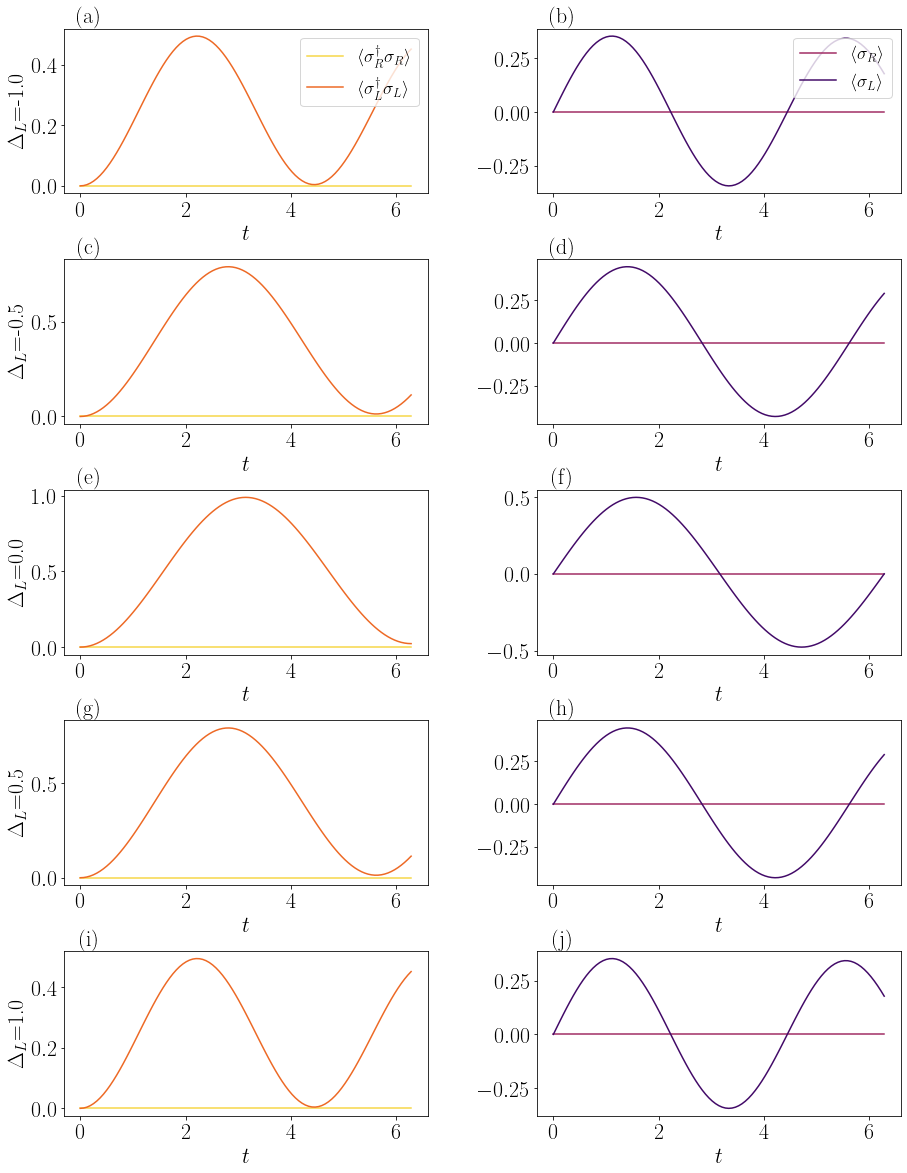

In [12]:
fig, axs = plt.subplots(10, figsize=(15,20))
gs = gridspec.GridSpec(5,2, wspace = 0.3, hspace=0.4)

number_colors = 4
colors1 = plt.cm.inferno(np.linspace(0.9,0.2,number_colors))
#colors2 = plt.cm.plasma(np.linspace(0.8,0.2,number_colors))
  
for i, det in enumerate(detuning_range):

    tab0 = result_gdown[det].expect[0]
    tab1 = result_gdown[det].expect[1]
    tab2 = result_gdown[det].expect[2]
    tab3 = result_gdown[det].expect[3]
    
    
    
    axs[2*i].plot(t_range, tab0, color=colors1[0], label = r"$\langle\sigma_R^\dagger\sigma_R\rangle$")
    axs[2*i].plot(t_range, tab1, color=colors1[1],label = r"$\langle\sigma_L^\dagger\sigma_L\rangle$")
    axs[2*i].tick_params(axis='x', labelsize=22)
    axs[2*i].tick_params(axis='y', labelsize=22)
    axs[2*i].set_xlabel('$t$',fontsize = 22)
    axs[2*i].set_position(gs[2*i].get_position(fig))
    axs[2*i].set_ylabel(r'$\Delta_L$='+str(det),fontsize = 22)
    
    
    axs[2*i+1].plot(t_range, np.real(tab2), color=colors1[2], label = r"$\langle\sigma_R\rangle$")
    axs[2*i+1].plot(t_range, np.real(tab3), color=colors1[3], label = r"$\langle\sigma_L\rangle$")    
    axs[2*i+1].tick_params(axis='x', labelsize=22)
    axs[2*i+1].tick_params(axis='y', labelsize=22)
    axs[2*i+1].set_xlabel('$t$',fontsize = 22)
    axs[2*i+1].set_position(gs[2*i+1].get_position(fig)) 
   
    
    if i == 0:
        axs[2*i].legend(loc = 'upper right',fontsize = 18)
        axs[2*i+1].legend(loc = 'upper right',fontsize = 18)
    


axs[0].set_title('(a)', position = (0.07,0.85),fontsize = 22)

axs[1].set_title('(b)', position = (0.07,0.85),fontsize = 22)

axs[2].set_title('(c)', position = (0.07,0.85),fontsize = 22)

axs[3].set_title('(d)', position = (0.07,0.85),fontsize = 22)

axs[4].set_title('(e)', position = (0.07,0.85),fontsize = 22)

axs[5].set_title('(f)', position = (0.07,0.85),fontsize = 22)

axs[6].set_title('(g)', position = (0.07,0.85),fontsize = 22)

axs[7].set_title('(h)', position = (0.07,0.85),fontsize = 22)

axs[8].set_title('(i)', position = (0.07,0.85),fontsize = 22)

axs[9].set_title('(j)', position = (0.07,0.85),fontsize = 22)

plt.savefig('Coh-drive-sigmaRL-dyn-gdown.png',bbox_inches='tight') #Save sempre antes do show!
plt.show()

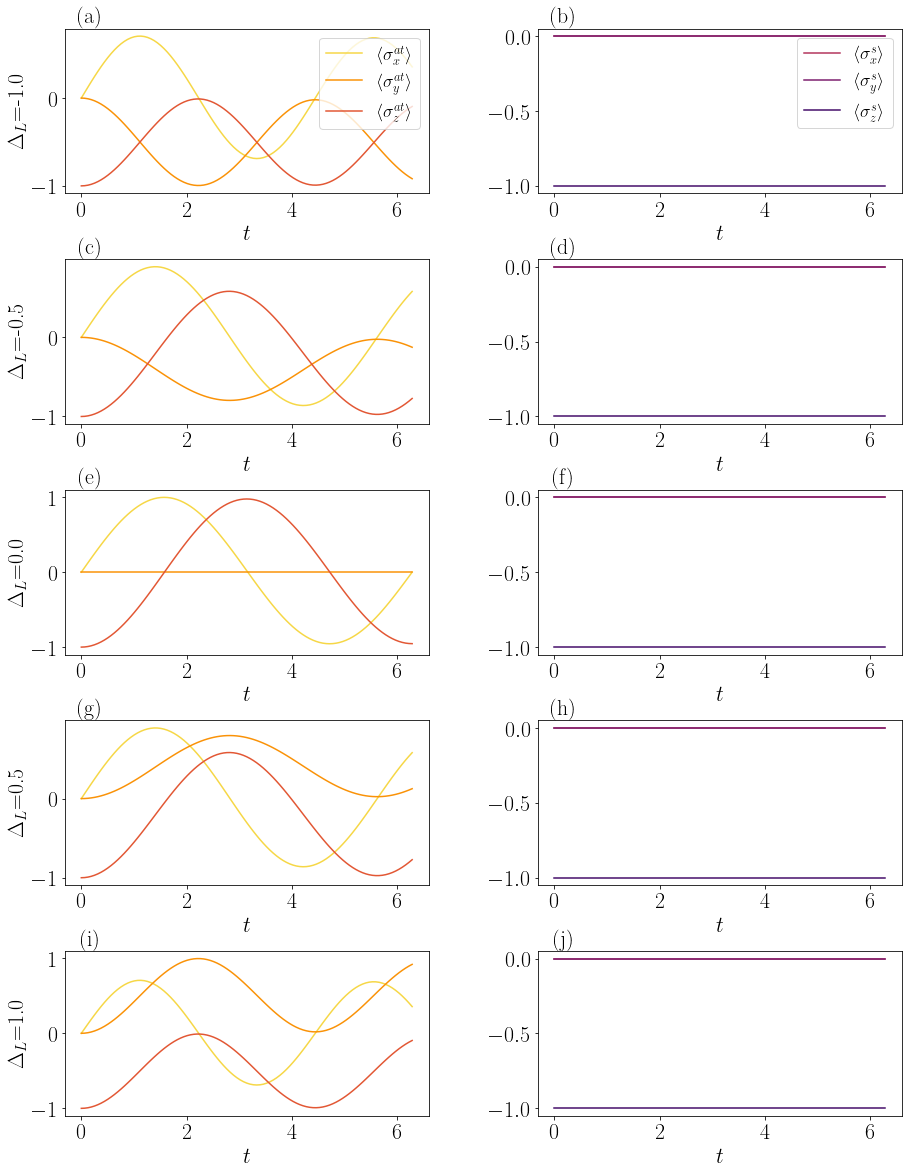

In [13]:
fig, axs = plt.subplots(10, figsize=(15,20))
gs = gridspec.GridSpec(5,2, wspace = 0.3, hspace=0.4)

number_colors = 6
colors1 = plt.cm.inferno(np.linspace(0.9,0.2,number_colors))
#colors2 = plt.cm.plasma(np.linspace(0.8,0.2,number_colors))
  
for i, det in enumerate(detuning_range):

    tab0 = result_gdown[det].expect[4]
    tab1 = result_gdown[det].expect[5]
    tab2 = result_gdown[det].expect[6]
    
    tab3 = result_gdown[det].expect[7]
    tab4 = result_gdown[det].expect[8]
    tab5 = result_gdown[det].expect[9]
    
    
    
    axs[2*i].plot(t_range, tab0, color=colors1[0], label = r"$\langle\sigma_x^{at}\rangle$")
    axs[2*i].plot(t_range, tab1, color=colors1[1],label = r"$\langle\sigma_y^{at}\rangle$")
    axs[2*i].plot(t_range, tab2, color=colors1[2],label = r"$\langle\sigma_z^{at}\rangle$")
    axs[2*i].tick_params(axis='x', labelsize=22)
    axs[2*i].tick_params(axis='y', labelsize=22)
    axs[2*i].set_xlabel('$t$',fontsize = 22)
    axs[2*i].set_position(gs[2*i].get_position(fig))
    axs[2*i].set_ylabel(r'$\Delta_L$='+str(det),fontsize = 22)
    
    axs[2*i+1].plot(t_range, tab3, color=colors1[3], label = r"$\langle\sigma_x^s\rangle$")
    axs[2*i+1].plot(t_range, tab4, color=colors1[4],label = r"$\langle\sigma_y^s\rangle$")
    axs[2*i+1].plot(t_range, tab5, color=colors1[5],label = r"$\langle\sigma_z^s\rangle$")
    axs[2*i+1].tick_params(axis='x', labelsize=22)
    axs[2*i+1].tick_params(axis='y', labelsize=22)
    axs[2*i+1].set_xlabel('$t$',fontsize = 22)
    axs[2*i+1].set_position(gs[2*i+1].get_position(fig))
    
    
        
    if i == 0:
        axs[2*i].legend(loc = 'upper right',fontsize = 18)
        axs[2*i+1].legend(loc = 'upper right',fontsize = 18)
           


axs[0].set_title('(a)', position = (0.07,0.85),fontsize = 22)

axs[1].set_title('(b)', position = (0.07,0.85),fontsize = 22)

axs[2].set_title('(c)', position = (0.07,0.85),fontsize = 22)

axs[3].set_title('(d)', position = (0.07,0.85),fontsize = 22)

axs[4].set_title('(e)', position = (0.07,0.85),fontsize = 22)

axs[5].set_title('(f)', position = (0.07,0.85),fontsize = 22)

axs[6].set_title('(g)', position = (0.07,0.85),fontsize = 22)

axs[7].set_title('(h)', position = (0.07,0.85),fontsize = 22)

axs[8].set_title('(i)', position = (0.07,0.85),fontsize = 22)

axs[9].set_title('(j)', position = (0.07,0.85),fontsize = 22)

plt.savefig('Coh-drive-sigma-ato-n-spin-dyn-gdown.png',bbox_inches='tight') #Save sempre antes do show!
plt.show()

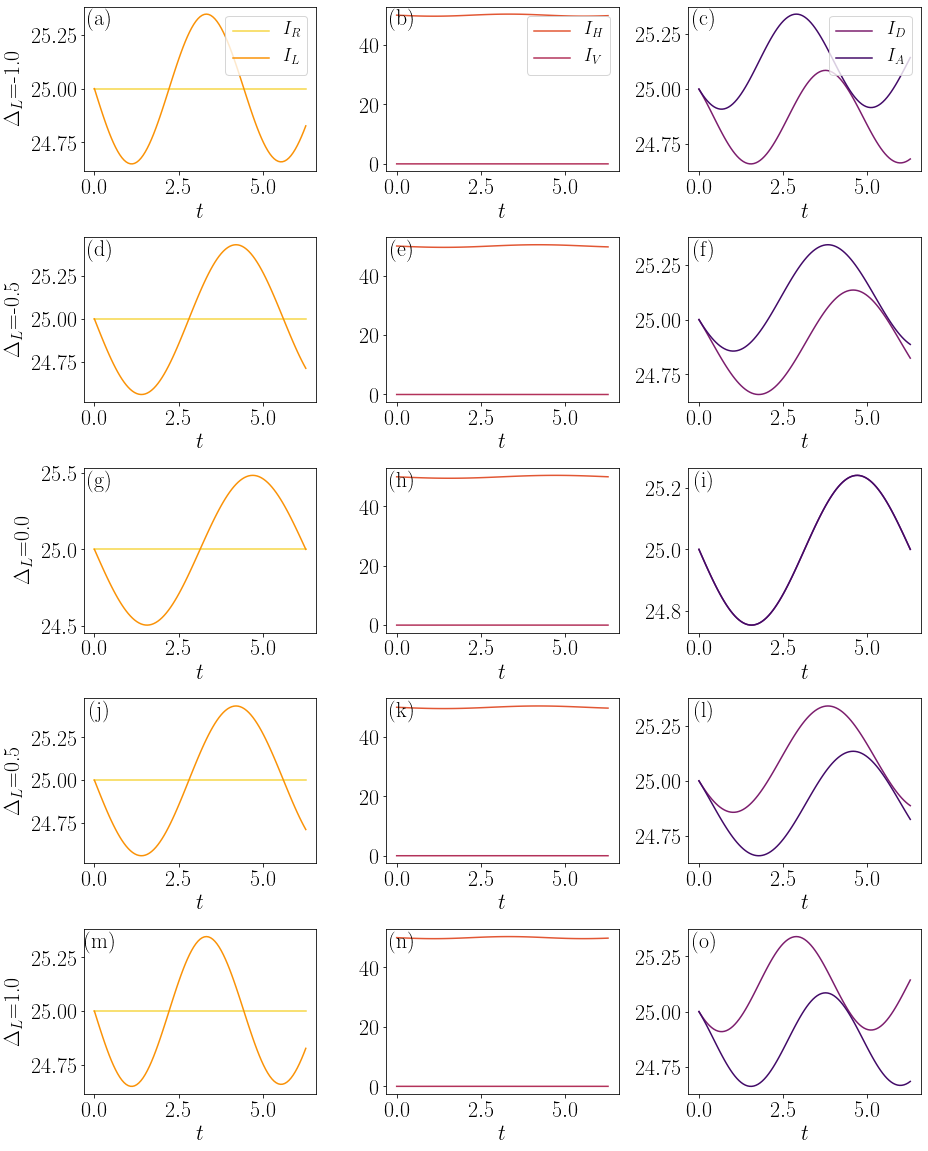

In [15]:
fig, axs = plt.subplots(15, figsize=(15,20))
gs = gridspec.GridSpec(5,3, wspace = 0.3, hspace=0.4)

number_colors = 6
colors1 = plt.cm.inferno(np.linspace(0.9,0.2,number_colors))
#colors2 = plt.cm.plasma(np.linspace(0.8,0.2,number_colors))
  
for i, det in enumerate(detuning_range):

    tab0 = I_R_gdown[det]
    tab1 = I_L_gdown[det]
    tab2 = I_H_gdown[det]
    tab3 = I_V_gdown[det]
    tab4 = I_D_gdown[det]
    tab5 = I_A_gdown[det]
    
    axs[3*i].plot(t_range, tab0, color=colors1[0], label = r"$I_R$")
    axs[3*i].plot(t_range, tab1, color=colors1[1],label = r"$I_L$")
    axs[3*i].tick_params(axis='x', labelsize=22)
    axs[3*i].tick_params(axis='y', labelsize=22)
    axs[3*i].set_xlabel('$t$',fontsize = 22)
    axs[3*i].set_position(gs[3*i].get_position(fig))
    axs[3*i].set_ylabel(r'$\Delta_L$='+str(det),fontsize = 22)
    
    
    axs[3*i+1].plot(t_range, tab2, color=colors1[2], label = r"$I_H$")
    axs[3*i+1].plot(t_range, tab3, color=colors1[3], label = r"$I_V$")    
    axs[3*i+1].tick_params(axis='x', labelsize=22)
    axs[3*i+1].tick_params(axis='y', labelsize=22)
    axs[3*i+1].set_xlabel('$t$',fontsize = 22)
    axs[3*i+1].set_position(gs[3*i+1].get_position(fig)) 
   
    axs[3*i+2].plot(t_range, tab4, color=colors1[4], label = r"$I_D$")
    axs[3*i+2].plot(t_range, tab5, color=colors1[5], label = r"$I_A$")    
    axs[3*i+2].tick_params(axis='x', labelsize=22)
    axs[3*i+2].tick_params(axis='y', labelsize=22)
    axs[3*i+2].set_xlabel('$t$',fontsize = 22)
    axs[3*i+2].set_position(gs[3*i+2].get_position(fig)) 
    
    if i == 0:
        axs[3*i].legend(loc = 'upper right',fontsize = 18)
        axs[3*i+1].legend(loc = 'upper right',fontsize = 18)
        axs[3*i+2].legend(loc = 'upper right',fontsize = 18)
    


axs[0].set_title('(a)', position = (0.07,0.85),fontsize = 22)

axs[1].set_title('(b)', position = (0.07,0.85),fontsize = 22)

axs[2].set_title('(c)', position = (0.07,0.85),fontsize = 22)

axs[3].set_title('(d)', position = (0.07,0.85),fontsize = 22)

axs[4].set_title('(e)', position = (0.07,0.85),fontsize = 22)

axs[5].set_title('(f)', position = (0.07,0.85),fontsize = 22)

axs[6].set_title('(g)', position = (0.07,0.85),fontsize = 22)

axs[7].set_title('(h)', position = (0.07,0.85),fontsize = 22)

axs[8].set_title('(i)', position = (0.07,0.85),fontsize = 22)

axs[9].set_title('(j)', position = (0.07,0.85),fontsize = 22)

axs[10].set_title('(k)', position = (0.07,0.85),fontsize = 22)

axs[11].set_title('(l)', position = (0.07,0.85),fontsize = 22)

axs[12].set_title('(m)', position = (0.07,0.85),fontsize = 22)

axs[13].set_title('(n)', position = (0.07,0.85),fontsize = 22)

axs[14].set_title('(o)', position = (0.07,0.85),fontsize = 22)

plt.savefig('Coh-drive-intensities-dyn-gdown.png',bbox_inches='tight') #Save sempre antes do show!
plt.show()

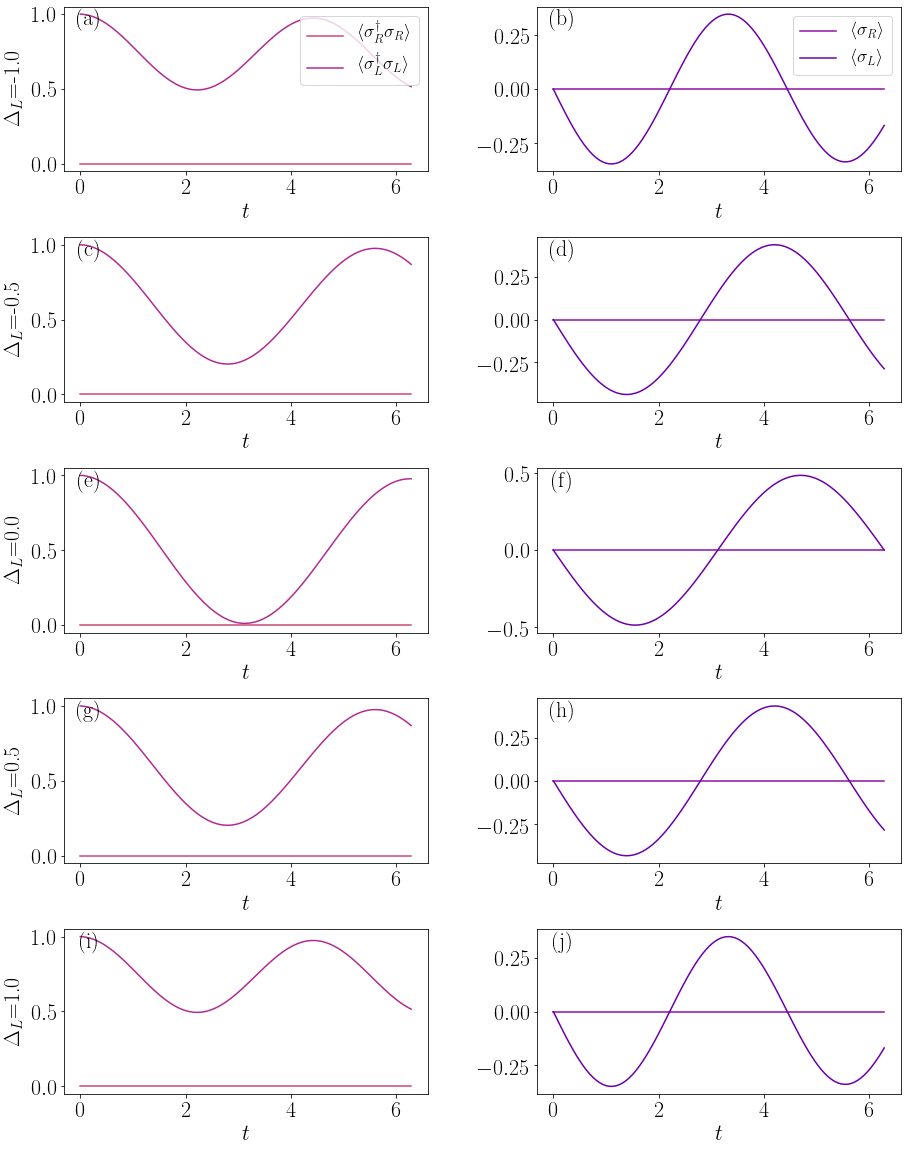

In [16]:
fig, axs = plt.subplots(10, figsize=(15,20))
gs = gridspec.GridSpec(5,2, wspace = 0.3, hspace=0.4)

number_colors = 4
colors1 = plt.cm.plasma(np.linspace(0.5,0.2,number_colors))
#colors2 = plt.cm.plasma(np.linspace(0.8,0.2,number_colors))
  
for i, det in enumerate(detuning_range):

    tab0 = result_edown[det].expect[0]
    tab1 = result_edown[det].expect[1]
    tab2 = result_edown[det].expect[2]
    tab3 = result_edown[det].expect[3]
    
    
    
    axs[2*i].plot(t_range, tab0, color=colors1[0], label = r"$\langle\sigma_R^\dagger\sigma_R\rangle$")
    axs[2*i].plot(t_range, tab1, color=colors1[1],label = r"$\langle\sigma_L^\dagger\sigma_L\rangle$")
    axs[2*i].tick_params(axis='x', labelsize=22)
    axs[2*i].tick_params(axis='y', labelsize=22)
    axs[2*i].set_xlabel('$t$',fontsize = 22)
    axs[2*i].set_position(gs[2*i].get_position(fig))
    axs[2*i].set_ylabel(r'$\Delta_L$='+str(det),fontsize = 22)
    
    
    axs[2*i+1].plot(t_range, np.real(tab2), color=colors1[2], label = r"$\langle\sigma_R\rangle$")
    axs[2*i+1].plot(t_range, np.real(tab3), color=colors1[3], label = r"$\langle\sigma_L\rangle$")    
    axs[2*i+1].tick_params(axis='x', labelsize=22)
    axs[2*i+1].tick_params(axis='y', labelsize=22)
    axs[2*i+1].set_xlabel('$t$',fontsize = 22)
    axs[2*i+1].set_position(gs[2*i+1].get_position(fig)) 
   
    
    if i == 0:
        axs[2*i].legend(loc = 'upper right',fontsize = 18)
        axs[2*i+1].legend(loc = 'upper right',fontsize = 18)
    


axs[0].set_title('(a)', position = (0.07,0.85),fontsize = 22)

axs[1].set_title('(b)', position = (0.07,0.85),fontsize = 22)

axs[2].set_title('(c)', position = (0.07,0.85),fontsize = 22)

axs[3].set_title('(d)', position = (0.07,0.85),fontsize = 22)

axs[4].set_title('(e)', position = (0.07,0.85),fontsize = 22)

axs[5].set_title('(f)', position = (0.07,0.85),fontsize = 22)

axs[6].set_title('(g)', position = (0.07,0.85),fontsize = 22)

axs[7].set_title('(h)', position = (0.07,0.85),fontsize = 22)

axs[8].set_title('(i)', position = (0.07,0.85),fontsize = 22)

axs[9].set_title('(j)', position = (0.07,0.85),fontsize = 22)

plt.savefig('Coh-drive-sigmaRL-dyn-edown.png',bbox_inches='tight') #Save sempre antes do show!
plt.show()

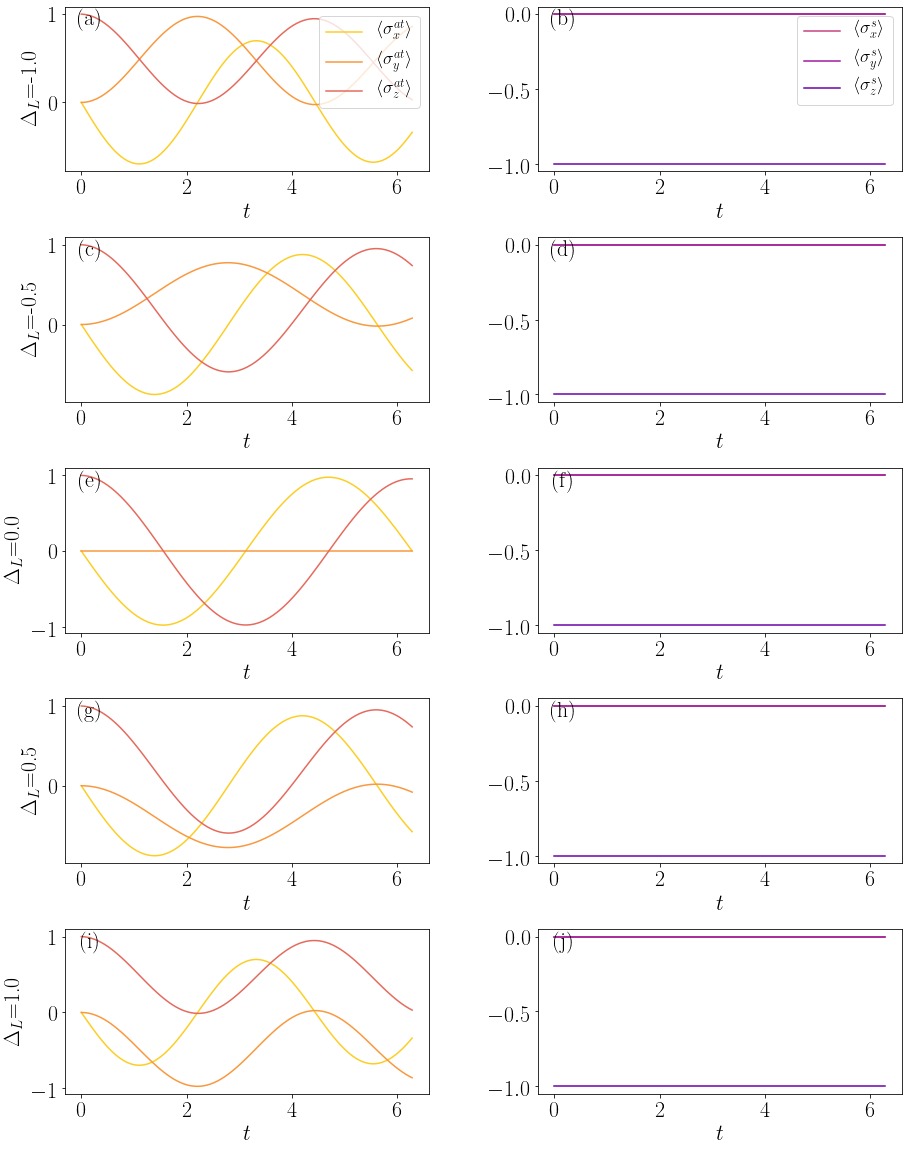

In [17]:
fig, axs = plt.subplots(10, figsize=(15,20))
gs = gridspec.GridSpec(5,2, wspace = 0.3, hspace=0.4)

number_colors = 6
colors1 = plt.cm.plasma(np.linspace(0.9,0.2,number_colors))
#colors2 = plt.cm.plasma(np.linspace(0.8,0.2,number_colors))
  
for i, det in enumerate(detuning_range):

    tab0 = result_edown[det].expect[4]
    tab1 = result_edown[det].expect[5]
    tab2 = result_edown[det].expect[6]
    
    tab3 = result_edown[det].expect[7]
    tab4 = result_edown[det].expect[8]
    tab5 = result_edown[det].expect[9]
    
    
    
    axs[2*i].plot(t_range, tab0, color=colors1[0], label = r"$\langle\sigma_x^{at}\rangle$")
    axs[2*i].plot(t_range, tab1, color=colors1[1],label = r"$\langle\sigma_y^{at}\rangle$")
    axs[2*i].plot(t_range, tab2, color=colors1[2],label = r"$\langle\sigma_z^{at}\rangle$")
    axs[2*i].tick_params(axis='x', labelsize=22)
    axs[2*i].tick_params(axis='y', labelsize=22)
    axs[2*i].set_xlabel('$t$',fontsize = 22)
    axs[2*i].set_position(gs[2*i].get_position(fig))
    axs[2*i].set_ylabel(r'$\Delta_L$='+str(det),fontsize = 22)
    
    axs[2*i+1].plot(t_range, tab3, color=colors1[3], label = r"$\langle\sigma_x^s\rangle$")
    axs[2*i+1].plot(t_range, tab4, color=colors1[4],label = r"$\langle\sigma_y^s\rangle$")
    axs[2*i+1].plot(t_range, tab5, color=colors1[5],label = r"$\langle\sigma_z^s\rangle$")
    axs[2*i+1].tick_params(axis='x', labelsize=22)
    axs[2*i+1].tick_params(axis='y', labelsize=22)
    axs[2*i+1].set_xlabel('$t$',fontsize = 22)
    axs[2*i+1].set_position(gs[2*i+1].get_position(fig))
    
    
        
    if i == 0:
        axs[2*i].legend(loc = 'upper right',fontsize = 18)
        axs[2*i+1].legend(loc = 'upper right',fontsize = 18)
           


axs[0].set_title('(a)', position = (0.07,0.85),fontsize = 22)

axs[1].set_title('(b)', position = (0.07,0.85),fontsize = 22)

axs[2].set_title('(c)', position = (0.07,0.85),fontsize = 22)

axs[3].set_title('(d)', position = (0.07,0.85),fontsize = 22)

axs[4].set_title('(e)', position = (0.07,0.85),fontsize = 22)

axs[5].set_title('(f)', position = (0.07,0.85),fontsize = 22)

axs[6].set_title('(g)', position = (0.07,0.85),fontsize = 22)

axs[7].set_title('(h)', position = (0.07,0.85),fontsize = 22)

axs[8].set_title('(i)', position = (0.07,0.85),fontsize = 22)

axs[9].set_title('(j)', position = (0.07,0.85),fontsize = 22)

plt.savefig('Coh-drive-sigma-ato-n-spin-dyn-edown.png',bbox_inches='tight') #Save sempre antes do show!
plt.show()

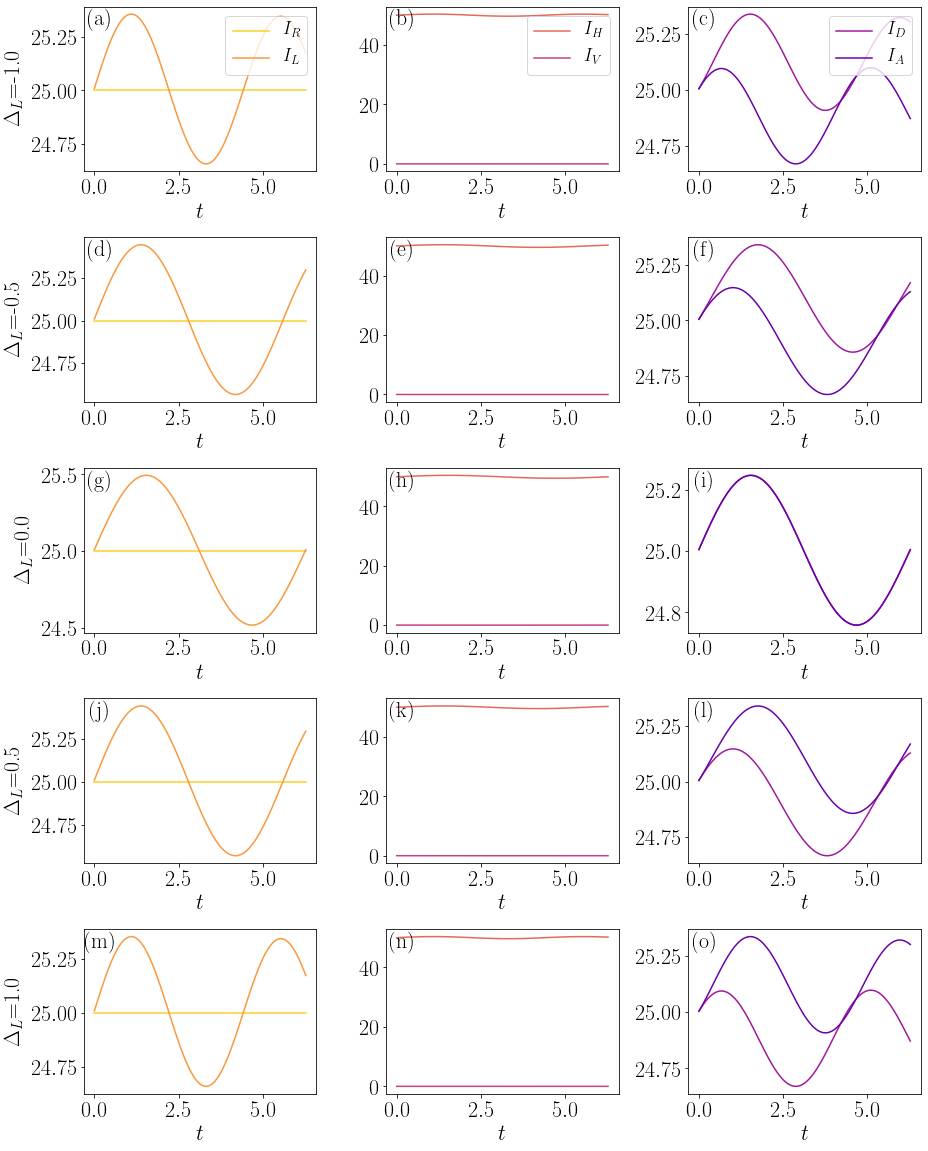

In [18]:
fig, axs = plt.subplots(15, figsize=(15,20))
gs = gridspec.GridSpec(5,3, wspace = 0.3, hspace=0.4)

number_colors = 6
colors1 = plt.cm.plasma(np.linspace(0.9,0.2,number_colors))
#colors2 = plt.cm.plasma(np.linspace(0.8,0.2,number_colors))
  
for i, det in enumerate(detuning_range):

    tab0 = I_R_edown[det]
    tab1 = I_L_edown[det]
    tab2 = I_H_edown[det]
    tab3 = I_V_edown[det]
    tab4 = I_D_edown[det]
    tab5 = I_A_edown[det]
    
    axs[3*i].plot(t_range, tab0, color=colors1[0], label = r"$I_R$")
    axs[3*i].plot(t_range, tab1, color=colors1[1],label = r"$I_L$")
    axs[3*i].tick_params(axis='x', labelsize=22)
    axs[3*i].tick_params(axis='y', labelsize=22)
    axs[3*i].set_xlabel('$t$',fontsize = 22)
    axs[3*i].set_position(gs[3*i].get_position(fig))
    axs[3*i].set_ylabel(r'$\Delta_L$='+str(det),fontsize = 22)
    
    
    axs[3*i+1].plot(t_range, tab2, color=colors1[2], label = r"$I_H$")
    axs[3*i+1].plot(t_range, tab3, color=colors1[3], label = r"$I_V$")    
    axs[3*i+1].tick_params(axis='x', labelsize=22)
    axs[3*i+1].tick_params(axis='y', labelsize=22)
    axs[3*i+1].set_xlabel('$t$',fontsize = 22)
    axs[3*i+1].set_position(gs[3*i+1].get_position(fig)) 
   
    axs[3*i+2].plot(t_range, tab4, color=colors1[4], label = r"$I_D$")
    axs[3*i+2].plot(t_range, tab5, color=colors1[5], label = r"$I_A$")    
    axs[3*i+2].tick_params(axis='x', labelsize=22)
    axs[3*i+2].tick_params(axis='y', labelsize=22)
    axs[3*i+2].set_xlabel('$t$',fontsize = 22)
    axs[3*i+2].set_position(gs[3*i+2].get_position(fig)) 
    
    if i == 0:
        axs[3*i].legend(loc = 'upper right',fontsize = 18)
        axs[3*i+1].legend(loc = 'upper right',fontsize = 18)
        axs[3*i+2].legend(loc = 'upper right',fontsize = 18)
    


axs[0].set_title('(a)', position = (0.07,0.85),fontsize = 22)

axs[1].set_title('(b)', position = (0.07,0.85),fontsize = 22)

axs[2].set_title('(c)', position = (0.07,0.85),fontsize = 22)

axs[3].set_title('(d)', position = (0.07,0.85),fontsize = 22)

axs[4].set_title('(e)', position = (0.07,0.85),fontsize = 22)

axs[5].set_title('(f)', position = (0.07,0.85),fontsize = 22)

axs[6].set_title('(g)', position = (0.07,0.85),fontsize = 22)

axs[7].set_title('(h)', position = (0.07,0.85),fontsize = 22)

axs[8].set_title('(i)', position = (0.07,0.85),fontsize = 22)

axs[9].set_title('(j)', position = (0.07,0.85),fontsize = 22)

axs[10].set_title('(k)', position = (0.07,0.85),fontsize = 22)

axs[11].set_title('(l)', position = (0.07,0.85),fontsize = 22)

axs[12].set_title('(m)', position = (0.07,0.85),fontsize = 22)

axs[13].set_title('(n)', position = (0.07,0.85),fontsize = 22)

axs[14].set_title('(o)', position = (0.07,0.85),fontsize = 22)

plt.savefig('Coh-drive-intensities-dyn-edown.png',bbox_inches='tight') #Save sempre antes do show!
plt.show()

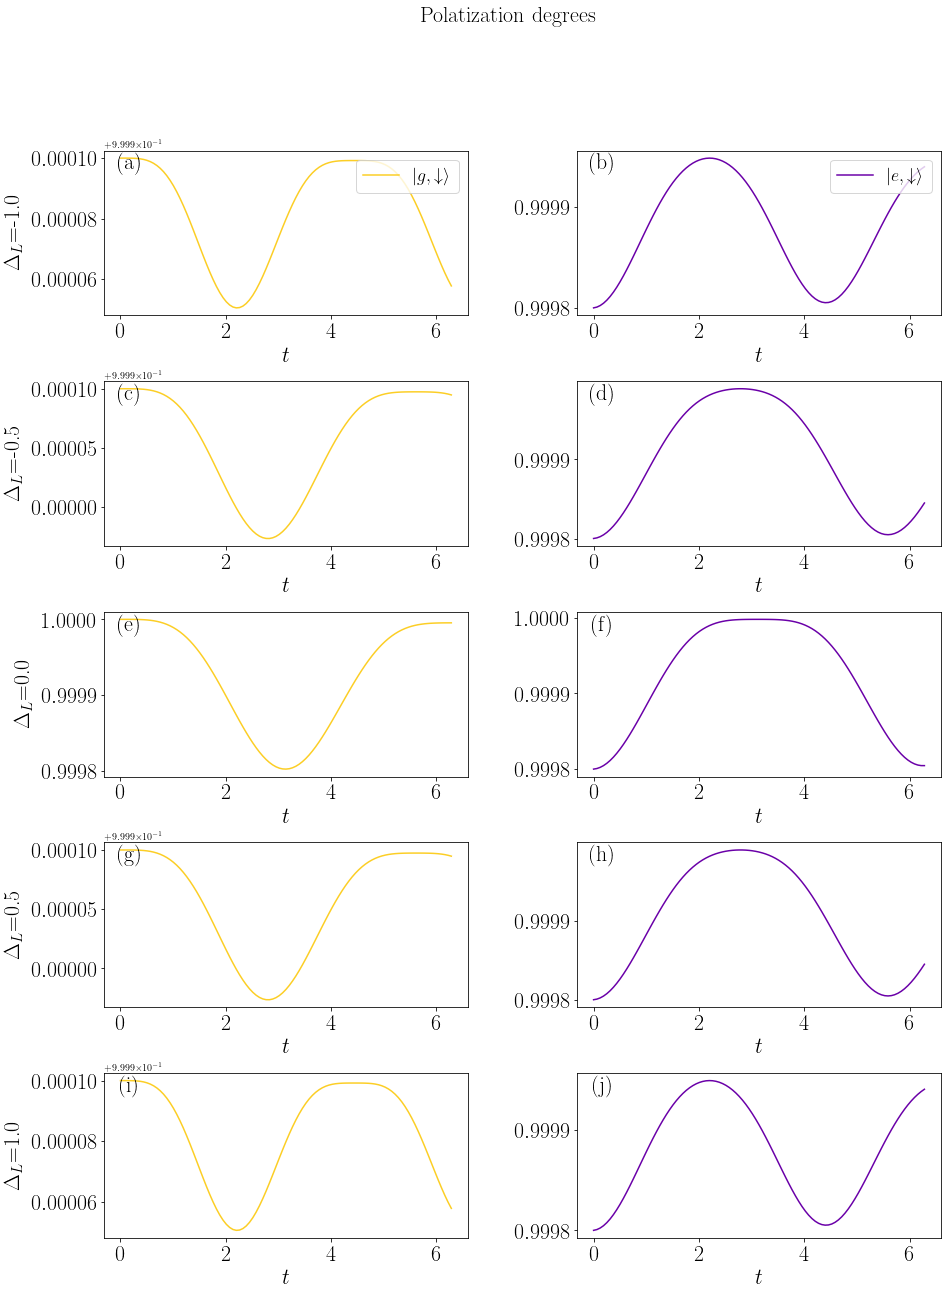

In [19]:
fig, axs = plt.subplots(10, figsize=(15,20))
gs = gridspec.GridSpec(5,2, wspace = 0.3, hspace=0.4)

number_colors = 2
colors1 = plt.cm.plasma(np.linspace(0.9,0.2,number_colors))
#colors2 = plt.cm.plasma(np.linspace(0.8,0.2,number_colors))
  
for i, det in enumerate(detuning_range):

    tab0 = polarization_deg_gdown[det]
    tab1 = polarization_deg_edown[det]
    
    
    axs[2*i].plot(t_range, tab0, color=colors1[0], label = r"$|g,\downarrow \rangle$") #, label = r"$\langle\sigma_x^{at}\rangle$")
    axs[2*i].tick_params(axis='x', labelsize=22)
    axs[2*i].tick_params(axis='y', labelsize=22)
    axs[2*i].set_xlabel('$t$',fontsize = 22)
    axs[2*i].set_position(gs[2*i].get_position(fig))
    axs[2*i].set_ylabel(r'$\Delta_L$='+str(det),fontsize = 22)
    
    axs[2*i+1].plot(t_range, tab1, color=colors1[1],label = r"$|e,\downarrow \rangle$")#, label = r"$\langle\sigma_x^s\rangle$")
    axs[2*i+1].tick_params(axis='x', labelsize=22)
    axs[2*i+1].tick_params(axis='y', labelsize=22)
    axs[2*i+1].set_xlabel('$t$',fontsize = 22)
    axs[2*i+1].set_position(gs[2*i+1].get_position(fig))
    
    
        
    if i == 0:
        axs[2*i].legend(loc = 'upper right',fontsize = 18)
        axs[2*i+1].legend(loc = 'upper right',fontsize = 18)
        
           


axs[0].set_title('(a)', position = (0.07,0.85),fontsize = 22)

axs[1].set_title('(b)', position = (0.07,0.85),fontsize = 22)

axs[2].set_title('(c)', position = (0.07,0.85),fontsize = 22)

axs[3].set_title('(d)', position = (0.07,0.85),fontsize = 22)

axs[4].set_title('(e)', position = (0.07,0.85),fontsize = 22)

axs[5].set_title('(f)', position = (0.07,0.85),fontsize = 22)

axs[6].set_title('(g)', position = (0.07,0.85),fontsize = 22)

axs[7].set_title('(h)', position = (0.07,0.85),fontsize = 22)

axs[8].set_title('(i)', position = (0.07,0.85),fontsize = 22)

axs[9].set_title('(j)', position = (0.07,0.85),fontsize = 22)

fig.suptitle('Polatization degrees', fontsize=22)
plt.savefig('Coh-drive-polarization-deg-dyn-gedown.png',bbox_inches='tight') #Save sempre antes do show!
plt.show()

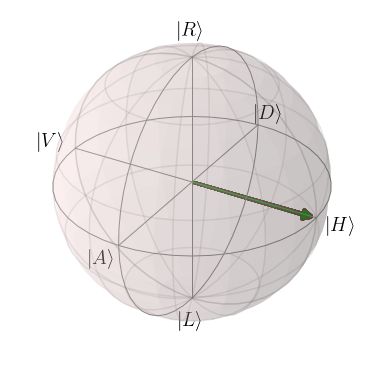

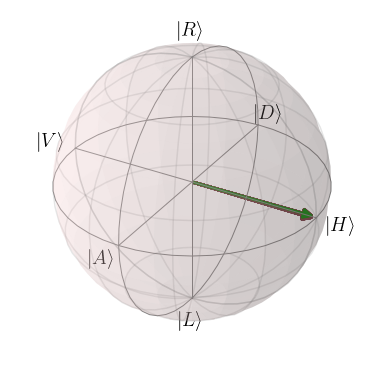

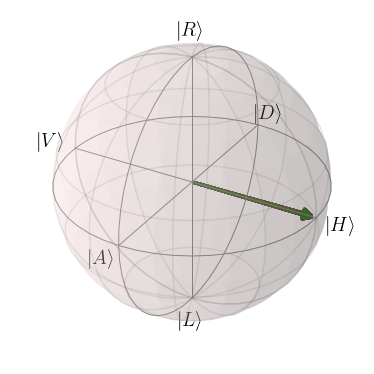

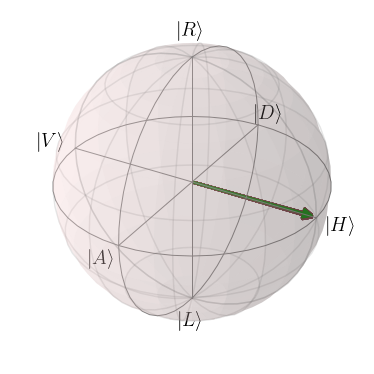

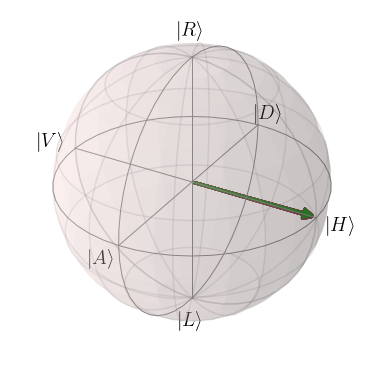

In [20]:
b = dict()
for det in detuning_range:
    b[det] = Bloch()

    #b.view = [-0,-90]
    b[det].xlabel= [r'$\left|A\right>$', r'$\left|D\right>$']
    b[det].ylabel= [r'$\left|H\right>$', r'$\left|V\right>$']
    b[det].zlabel= [r'$\left|R\right>$', r'$\left|L\right>$']
    b[det].add_vectors(poin_vectors_gdown[det])
    b[det].show()

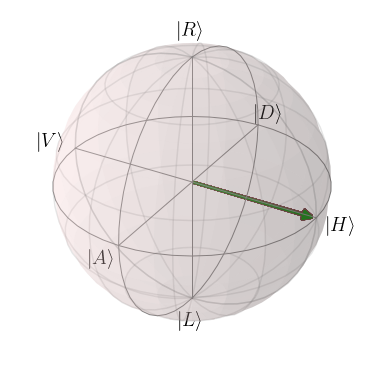

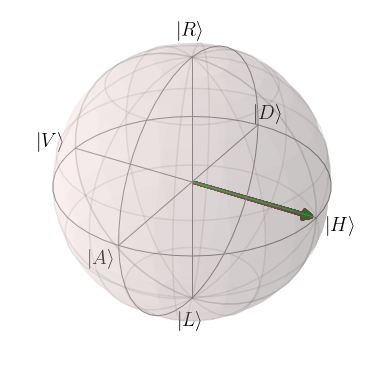

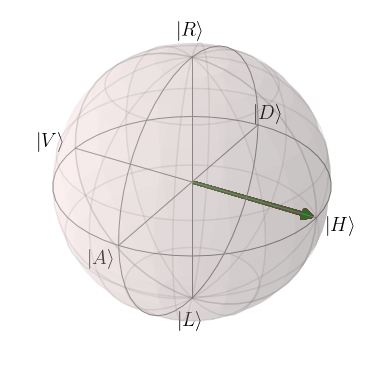

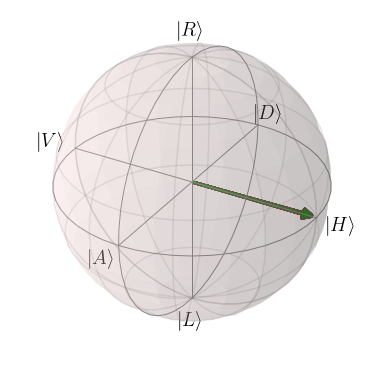

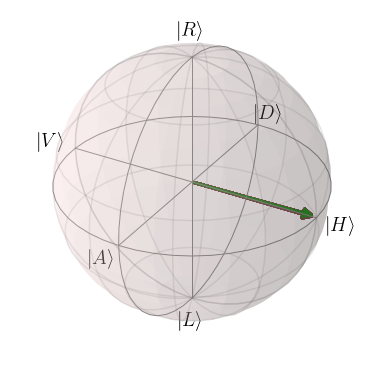

In [21]:
b = dict()
for det in detuning_range:
    b[det] = Bloch()

    #b.view = [-0,-90]
    b[det].xlabel= [r'$\left|A\right>$', r'$\left|D\right>$']
    b[det].ylabel= [r'$\left|H\right>$', r'$\left|V\right>$']
    b[det].zlabel= [r'$\left|R\right>$', r'$\left|L\right>$']
    b[det].add_vectors(poin_vectors_edown[det])
    b[det].show()

## Starting from $|g,\uparrow\rangle, |e,\uparrow\rangle$

In [237]:
#################################
#      Parameters
#################################

Omega = 1.0

# Drive amplitude 
Omega_R = Omega
Omega_L = 0.0

# Dissipation
gamma_L = 0.01*Omega
gamma_R = 0.01*Omega

# Amplitudes - Horizontally polarized
alpha_L = 1/(2*gamma_L**0.5)
alpha_R = 1/(2*gamma_R**0.5)

# Pure dephasing - No pure dephasing considered
Gamma_pd_L = 0.0*Omega
Gamma_pd_R = 0.0*Omega

# Detunings - no detuning here
# Delta_omega_L = 0*Omega_L
# Delta_omega_R = 0*Omega_R

detuning_range = np.arange(-Omega, Omega + 0.5, 0.5) # 5 values

# Time range
t_range = np.linspace(0,2*np.pi,101) #time changes from 0 to 2Pi/Omega with steps of Pi/(4 Omega) 
discrete_t_range = np.arange(0,2*np.pi,np.pi*(1/8))

# In the following we'll append the relevant operators depending on the parameters
c_ops = [] 

# Qubit dissipation for each polarization
rate_L = gamma_L
if rate_L > 0.0:
    c_ops.append(np.sqrt(rate_L)*sigma_L)
    
rate_R = gamma_R
if rate_R > 0.0:
    c_ops.append(np.sqrt(rate_R)*sigma_R)

    
# Relevant expectation values list 0-9
expec_list = [sigma_Rd*sigma_R, sigma_Ld*sigma_L,
              
              sigma_R, sigma_L,   
              
              sigma_x_at, sigma_y_at, sigma_z_at,
              
              sigma_x_spin, sigma_y_spin, sigma_z_spin]

In [248]:
#################################
#    Solving the master eqn. 
#################################

#Intial states
Psi_0_vec = [tensor(ket('1'),ket('1')), tensor(ket('1'),ket('0')), # ground state: down[0] and up[1]
             tensor(ket('0'),ket('1')), tensor(ket('0'),ket('0'))] # excited state: down[2] and up[3]

result_gup = dict()
result_eup = dict()
for Delta_R in detuning_range:
    result_gup[Delta_R] = mesolve(H_coh_drive(Delta_omega_L, Delta_R, Omega_L, Omega_R), Psi_0_vec[1], t_range, c_ops, expec_list)
    result_eup[Delta_R] = mesolve(H_coh_drive(Delta_omega_L, Delta_R, Omega_L, Omega_R), Psi_0_vec[3], t_range, c_ops, expec_list)

In [249]:
############################################
#      The intensities - gup and eup
############################################  
I_R_gup = dict()
I_L_gup = dict()
I_H_gup = dict()
I_V_gup = dict()
I_D_gup = dict()
I_A_gup = dict()
bdR_bL_gup = dict()
bdL_bR_gup = dict()

I_R_eup = dict()
I_L_eup = dict()
I_H_eup = dict()
I_V_eup = dict()
I_D_eup = dict()
I_A_eup = dict()
bdR_bL_eup = dict()
bdL_bR_eup = dict()

for i in detuning_range:

    I_R_gup[i] = np.real(gamma_R*result_gup[i].expect[0] - gamma_R**0.5*(alpha_R*np.conj(result_gup[i].expect[2]) + alpha_R*result_gup[i].expect[2])) + np.abs(alpha_R)**2
    I_L_gup[i] = np.real(gamma_L*result_gup[i].expect[1] - gamma_L**0.5*(alpha_L*np.conj(result_gup[i].expect[3]) + alpha_L*result_gup[i].expect[3])) + np.abs(alpha_L)**2

    bdR_bL_gup[i] = -gamma_L**0.5*alpha_L*np.conj(result_gup[i].expect[3]) + alpha_L*alpha_R
    bdL_bR_gup[i] = -gamma_L**0.5*alpha_L*result_gup[i].expect[3] + alpha_L*alpha_R

    I_H_gup[i] = np.real(0.5*(I_L_gup[i] + I_R_gup[i] + bdR_bL_gup[i] + bdL_bR_gup[i]))
    I_V_gup[i] = np.real(0.5*(I_L_gup[i] + I_R_gup[i] - (bdR_bL_gup[i] + bdL_bR_gup[i])))

    I_D_gup[i] = np.real(0.5*(I_L_gup[i] + I_R_gup[i] + 1j*(bdR_bL_gup[i] - bdL_bR_gup[i])))
    I_A_gup[i] = np.real(0.5*(I_L_gup[i] + I_R_gup[i] - 1j*(bdR_bL_gup[i] - bdL_bR_gup[i])))
    
    I_R_eup[i] = np.real(gamma_R*result_eup[i].expect[0] - gamma_R**0.5*(alpha_R*np.conj(result_eup[i].expect[2]) + alpha_R*result_eup[i].expect[2])) + np.abs(alpha_R)**2
    I_L_eup[i] = np.real(gamma_L*result_eup[i].expect[1] - gamma_L**0.5*(alpha_L*np.conj(result_eup[i].expect[3]) + alpha_L*result_eup[i].expect[3])) + np.abs(alpha_L)**2

    bdR_bL_eup[i] = -gamma_L**0.5*alpha_L*np.conj(result_eup[i].expect[3]) + alpha_L*alpha_R
    bdL_bR_eup[i] = -gamma_L**0.5*alpha_L*result_eup[i].expect[3] + alpha_L*alpha_R

    I_H_eup[i] = np.real(0.5*(I_L_eup[i] + I_R_eup[i] + bdR_bL_eup[i] + bdL_bR_eup[i]))
    I_V_eup[i] = np.real(0.5*(I_L_eup[i] + I_R_eup[i] - (bdR_bL_eup[i] + bdL_bR_eup[i])))

    I_D_eup[i] = np.real(0.5*(I_L_eup[i] + I_R_eup[i] + 1j*(bdR_bL_eup[i] - bdL_bR_eup[i])))
    I_A_eup[i] = np.real(0.5*(I_L_eup[i] + I_R_eup[i] - 1j*(bdR_bL_eup[i] - bdL_bR_eup[i])))

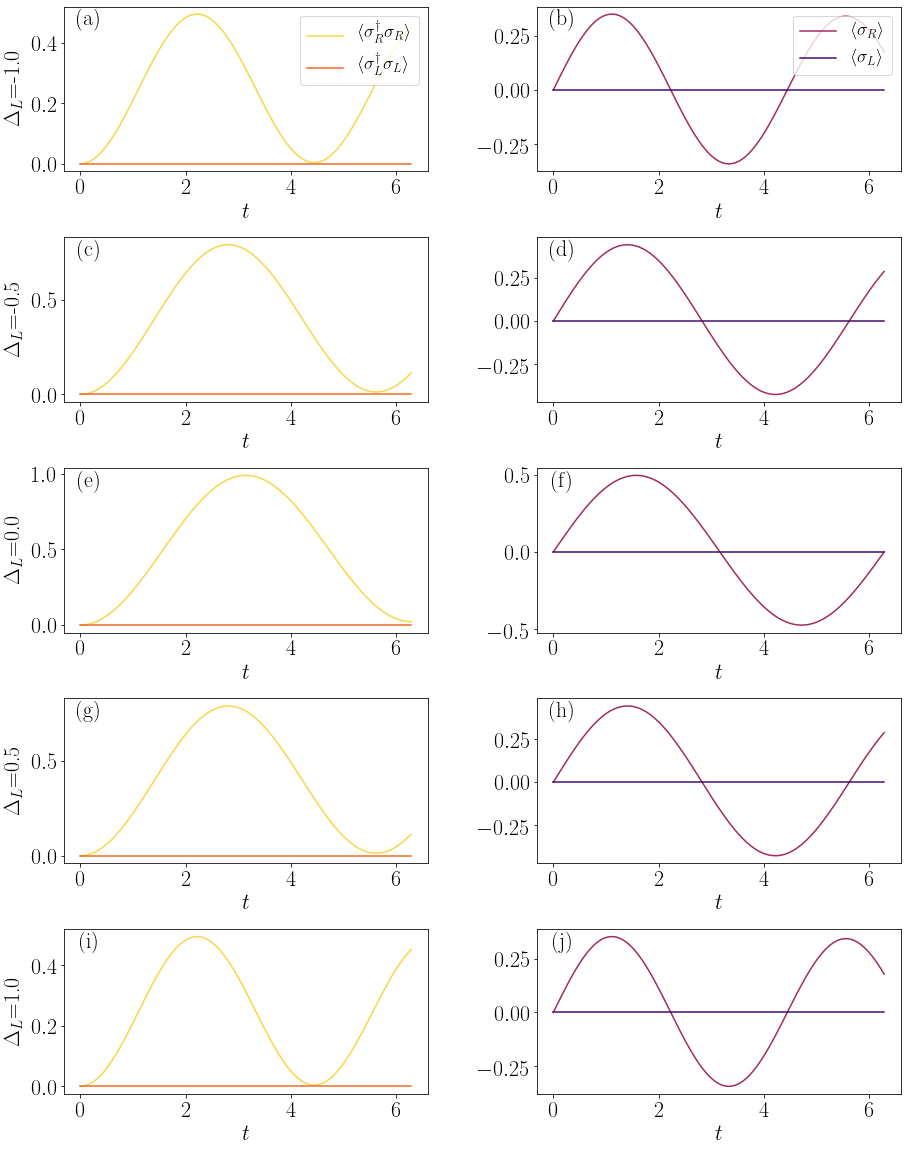

In [250]:
fig, axs = plt.subplots(10, figsize=(15,20))
gs = gridspec.GridSpec(5,2, wspace = 0.3, hspace=0.4)

number_colors = 4
colors1 = plt.cm.inferno(np.linspace(0.9,0.2,number_colors))
#colors2 = plt.cm.plasma(np.linspace(0.8,0.2,number_colors))
  
for i, det in enumerate(detuning_range):

    tab0 = result_gup[det].expect[0]
    tab1 = result_gup[det].expect[1]
    tab2 = result_gup[det].expect[2]
    tab3 = result_gup[det].expect[3]
    
    
    
    axs[2*i].plot(t_range, tab0, color=colors1[0], label = r"$\langle\sigma_R^\dagger\sigma_R\rangle$")
    axs[2*i].plot(t_range, tab1, color=colors1[1],label = r"$\langle\sigma_L^\dagger\sigma_L\rangle$")
    axs[2*i].tick_params(axis='x', labelsize=22)
    axs[2*i].tick_params(axis='y', labelsize=22)
    axs[2*i].set_xlabel('$t$',fontsize = 22)
    axs[2*i].set_position(gs[2*i].get_position(fig))
    axs[2*i].set_ylabel(r'$\Delta_L$='+str(det),fontsize = 22)
    
    
    axs[2*i+1].plot(t_range, np.real(tab2), color=colors1[2], label = r"$\langle\sigma_R\rangle$")
    axs[2*i+1].plot(t_range, np.real(tab3), color=colors1[3], label = r"$\langle\sigma_L\rangle$")    
    axs[2*i+1].tick_params(axis='x', labelsize=22)
    axs[2*i+1].tick_params(axis='y', labelsize=22)
    axs[2*i+1].set_xlabel('$t$',fontsize = 22)
    axs[2*i+1].set_position(gs[2*i+1].get_position(fig)) 
   
    
    if i == 0:
        axs[2*i].legend(loc = 'upper right',fontsize = 18)
        axs[2*i+1].legend(loc = 'upper right',fontsize = 18)
    


axs[0].set_title('(a)', position = (0.07,0.85),fontsize = 22)

axs[1].set_title('(b)', position = (0.07,0.85),fontsize = 22)

axs[2].set_title('(c)', position = (0.07,0.85),fontsize = 22)

axs[3].set_title('(d)', position = (0.07,0.85),fontsize = 22)

axs[4].set_title('(e)', position = (0.07,0.85),fontsize = 22)

axs[5].set_title('(f)', position = (0.07,0.85),fontsize = 22)

axs[6].set_title('(g)', position = (0.07,0.85),fontsize = 22)

axs[7].set_title('(h)', position = (0.07,0.85),fontsize = 22)

axs[8].set_title('(i)', position = (0.07,0.85),fontsize = 22)

axs[9].set_title('(j)', position = (0.07,0.85),fontsize = 22)

plt.show()

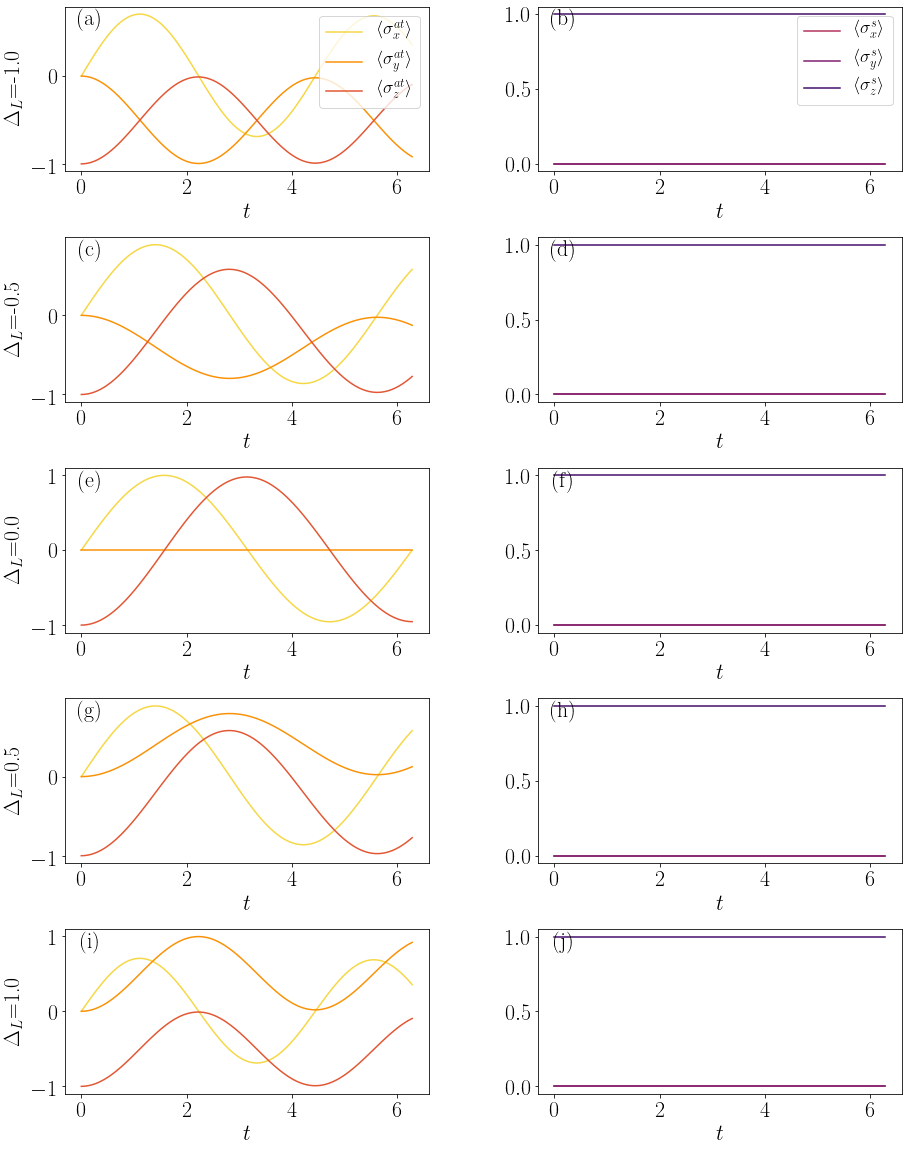

In [251]:
fig, axs = plt.subplots(10, figsize=(15,20))
gs = gridspec.GridSpec(5,2, wspace = 0.3, hspace=0.4)

number_colors = 6
colors1 = plt.cm.inferno(np.linspace(0.9,0.2,number_colors))
#colors2 = plt.cm.plasma(np.linspace(0.8,0.2,number_colors))
  
for i, det in enumerate(detuning_range):

    tab0 = result_gup[det].expect[4]
    tab1 = result_gup[det].expect[5]
    tab2 = result_gup[det].expect[6]
    
    tab3 = result_gup[det].expect[7]
    tab4 = result_gup[det].expect[8]
    tab5 = result_gup[det].expect[9]
    
    
    
    axs[2*i].plot(t_range, tab0, color=colors1[0], label = r"$\langle\sigma_x^{at}\rangle$")
    axs[2*i].plot(t_range, tab1, color=colors1[1],label = r"$\langle\sigma_y^{at}\rangle$")
    axs[2*i].plot(t_range, tab2, color=colors1[2],label = r"$\langle\sigma_z^{at}\rangle$")
    axs[2*i].tick_params(axis='x', labelsize=22)
    axs[2*i].tick_params(axis='y', labelsize=22)
    axs[2*i].set_xlabel('$t$',fontsize = 22)
    axs[2*i].set_position(gs[2*i].get_position(fig))
    axs[2*i].set_ylabel(r'$\Delta_L$='+str(det),fontsize = 22)
    
    axs[2*i+1].plot(t_range, tab3, color=colors1[3], label = r"$\langle\sigma_x^s\rangle$")
    axs[2*i+1].plot(t_range, tab4, color=colors1[4],label = r"$\langle\sigma_y^s\rangle$")
    axs[2*i+1].plot(t_range, tab5, color=colors1[5],label = r"$\langle\sigma_z^s\rangle$")
    axs[2*i+1].tick_params(axis='x', labelsize=22)
    axs[2*i+1].tick_params(axis='y', labelsize=22)
    axs[2*i+1].set_xlabel('$t$',fontsize = 22)
    axs[2*i+1].set_position(gs[2*i+1].get_position(fig))
    
    
        
    if i == 0:
        axs[2*i].legend(loc = 'upper right',fontsize = 18)
        axs[2*i+1].legend(loc = 'upper right',fontsize = 18)
           


axs[0].set_title('(a)', position = (0.07,0.85),fontsize = 22)

axs[1].set_title('(b)', position = (0.07,0.85),fontsize = 22)

axs[2].set_title('(c)', position = (0.07,0.85),fontsize = 22)

axs[3].set_title('(d)', position = (0.07,0.85),fontsize = 22)

axs[4].set_title('(e)', position = (0.07,0.85),fontsize = 22)

axs[5].set_title('(f)', position = (0.07,0.85),fontsize = 22)

axs[6].set_title('(g)', position = (0.07,0.85),fontsize = 22)

axs[7].set_title('(h)', position = (0.07,0.85),fontsize = 22)

axs[8].set_title('(i)', position = (0.07,0.85),fontsize = 22)

axs[9].set_title('(j)', position = (0.07,0.85),fontsize = 22)

plt.show()

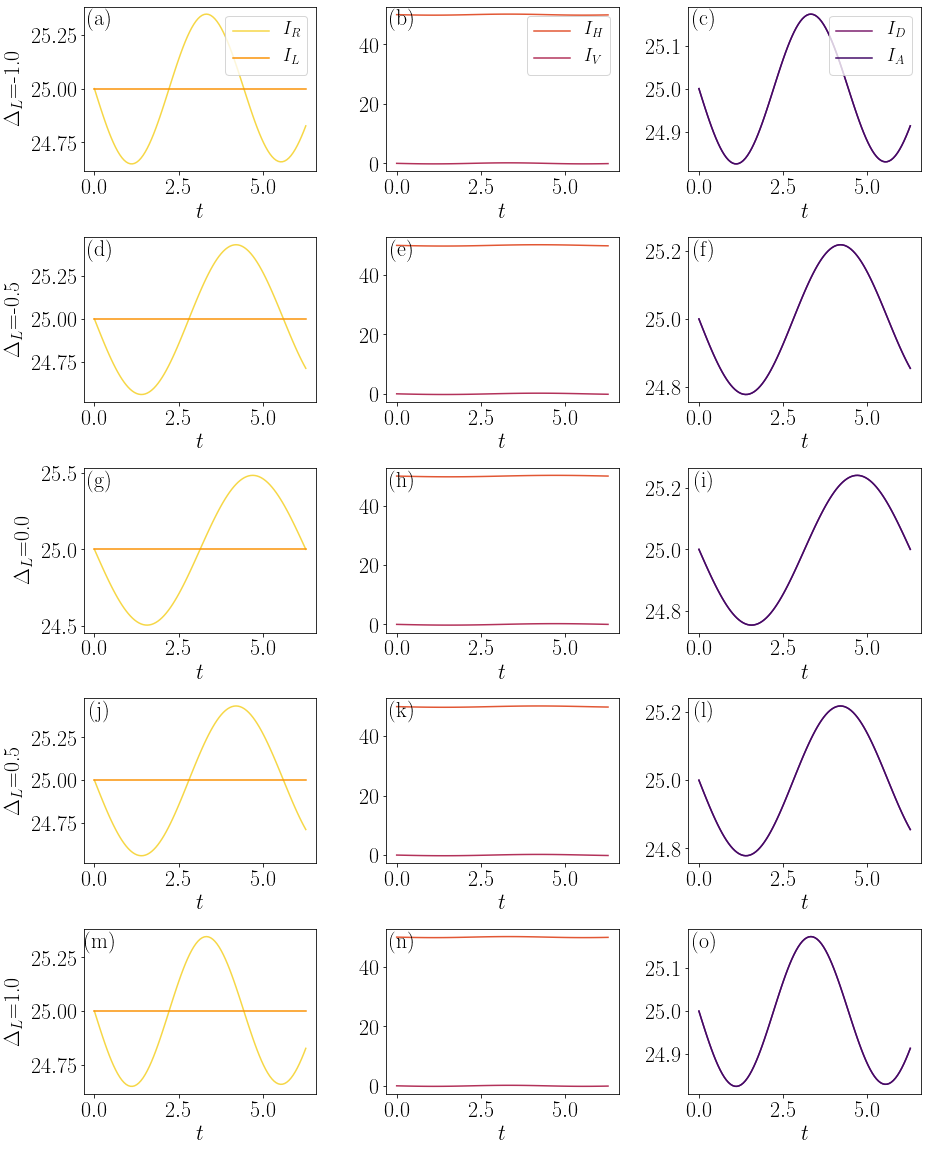

In [252]:
fig, axs = plt.subplots(15, figsize=(15,20))
gs = gridspec.GridSpec(5,3, wspace = 0.3, hspace=0.4)

number_colors = 6
colors1 = plt.cm.inferno(np.linspace(0.9,0.2,number_colors))
#colors2 = plt.cm.plasma(np.linspace(0.8,0.2,number_colors))
  
for i, det in enumerate(detuning_range):

    tab0 = I_R_gup[det]
    tab1 = I_L_gup[det]
    tab2 = I_H_gup[det]
    tab3 = I_V_gup[det]
    tab4 = I_D_gup[det]
    tab5 = I_A_gup[det]
    
    axs[3*i].plot(t_range, tab0, color=colors1[0], label = r"$I_R$")
    axs[3*i].plot(t_range, tab1, color=colors1[1],label = r"$I_L$")
    axs[3*i].tick_params(axis='x', labelsize=22)
    axs[3*i].tick_params(axis='y', labelsize=22)
    axs[3*i].set_xlabel('$t$',fontsize = 22)
    axs[3*i].set_position(gs[3*i].get_position(fig))
    axs[3*i].set_ylabel(r'$\Delta_L$='+str(det),fontsize = 22)
    
    
    axs[3*i+1].plot(t_range, tab2, color=colors1[2], label = r"$I_H$")
    axs[3*i+1].plot(t_range, tab3, color=colors1[3], label = r"$I_V$")    
    axs[3*i+1].tick_params(axis='x', labelsize=22)
    axs[3*i+1].tick_params(axis='y', labelsize=22)
    axs[3*i+1].set_xlabel('$t$',fontsize = 22)
    axs[3*i+1].set_position(gs[3*i+1].get_position(fig)) 
   
    axs[3*i+2].plot(t_range, tab4, color=colors1[4], label = r"$I_D$")
    axs[3*i+2].plot(t_range, tab5, color=colors1[5], label = r"$I_A$")    
    axs[3*i+2].tick_params(axis='x', labelsize=22)
    axs[3*i+2].tick_params(axis='y', labelsize=22)
    axs[3*i+2].set_xlabel('$t$',fontsize = 22)
    axs[3*i+2].set_position(gs[3*i+2].get_position(fig)) 
    
    if i == 0:
        axs[3*i].legend(loc = 'upper right',fontsize = 18)
        axs[3*i+1].legend(loc = 'upper right',fontsize = 18)
        axs[3*i+2].legend(loc = 'upper right',fontsize = 18)
    


axs[0].set_title('(a)', position = (0.07,0.85),fontsize = 22)

axs[1].set_title('(b)', position = (0.07,0.85),fontsize = 22)

axs[2].set_title('(c)', position = (0.07,0.85),fontsize = 22)

axs[3].set_title('(d)', position = (0.07,0.85),fontsize = 22)

axs[4].set_title('(e)', position = (0.07,0.85),fontsize = 22)

axs[5].set_title('(f)', position = (0.07,0.85),fontsize = 22)

axs[6].set_title('(g)', position = (0.07,0.85),fontsize = 22)

axs[7].set_title('(h)', position = (0.07,0.85),fontsize = 22)

axs[8].set_title('(i)', position = (0.07,0.85),fontsize = 22)

axs[9].set_title('(j)', position = (0.07,0.85),fontsize = 22)

axs[10].set_title('(k)', position = (0.07,0.85),fontsize = 22)

axs[11].set_title('(l)', position = (0.07,0.85),fontsize = 22)

axs[12].set_title('(m)', position = (0.07,0.85),fontsize = 22)

axs[13].set_title('(n)', position = (0.07,0.85),fontsize = 22)

axs[14].set_title('(o)', position = (0.07,0.85),fontsize = 22)

plt.show()

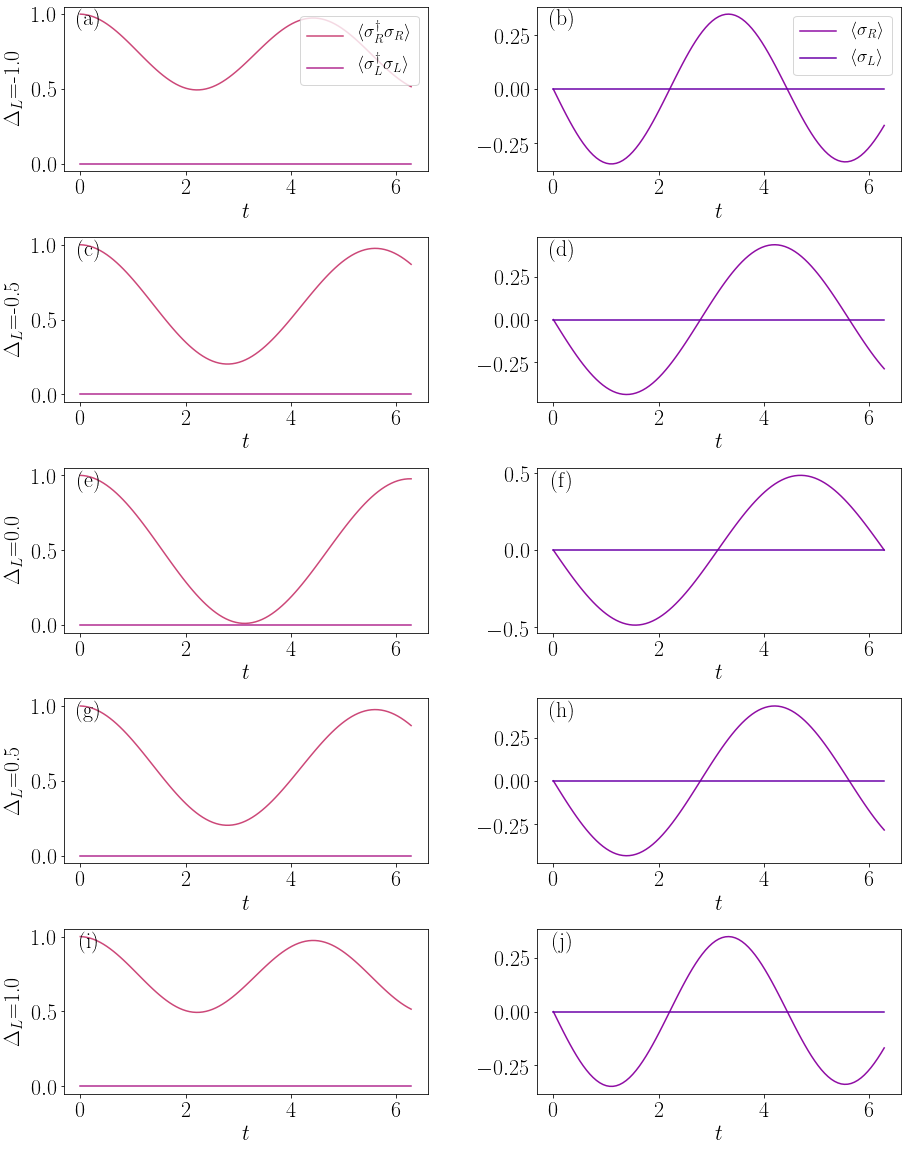

In [253]:
fig, axs = plt.subplots(10, figsize=(15,20))
gs = gridspec.GridSpec(5,2, wspace = 0.3, hspace=0.4)

number_colors = 4
colors1 = plt.cm.plasma(np.linspace(0.5,0.2,number_colors))
#colors2 = plt.cm.plasma(np.linspace(0.8,0.2,number_colors))
  
for i, det in enumerate(detuning_range):

    tab0 = result_eup[det].expect[0]
    tab1 = result_eup[det].expect[1]
    tab2 = result_eup[det].expect[2]
    tab3 = result_eup[det].expect[3]
    
    
    
    axs[2*i].plot(t_range, tab0, color=colors1[0], label = r"$\langle\sigma_R^\dagger\sigma_R\rangle$")
    axs[2*i].plot(t_range, tab1, color=colors1[1],label = r"$\langle\sigma_L^\dagger\sigma_L\rangle$")
    axs[2*i].tick_params(axis='x', labelsize=22)
    axs[2*i].tick_params(axis='y', labelsize=22)
    axs[2*i].set_xlabel('$t$',fontsize = 22)
    axs[2*i].set_position(gs[2*i].get_position(fig))
    axs[2*i].set_ylabel(r'$\Delta_L$='+str(det),fontsize = 22)
    
    
    axs[2*i+1].plot(t_range, np.real(tab2), color=colors1[2], label = r"$\langle\sigma_R\rangle$")
    axs[2*i+1].plot(t_range, np.real(tab3), color=colors1[3], label = r"$\langle\sigma_L\rangle$")    
    axs[2*i+1].tick_params(axis='x', labelsize=22)
    axs[2*i+1].tick_params(axis='y', labelsize=22)
    axs[2*i+1].set_xlabel('$t$',fontsize = 22)
    axs[2*i+1].set_position(gs[2*i+1].get_position(fig)) 
   
    
    if i == 0:
        axs[2*i].legend(loc = 'upper right',fontsize = 18)
        axs[2*i+1].legend(loc = 'upper right',fontsize = 18)
    


axs[0].set_title('(a)', position = (0.07,0.85),fontsize = 22)

axs[1].set_title('(b)', position = (0.07,0.85),fontsize = 22)

axs[2].set_title('(c)', position = (0.07,0.85),fontsize = 22)

axs[3].set_title('(d)', position = (0.07,0.85),fontsize = 22)

axs[4].set_title('(e)', position = (0.07,0.85),fontsize = 22)

axs[5].set_title('(f)', position = (0.07,0.85),fontsize = 22)

axs[6].set_title('(g)', position = (0.07,0.85),fontsize = 22)

axs[7].set_title('(h)', position = (0.07,0.85),fontsize = 22)

axs[8].set_title('(i)', position = (0.07,0.85),fontsize = 22)

axs[9].set_title('(j)', position = (0.07,0.85),fontsize = 22)

plt.show()

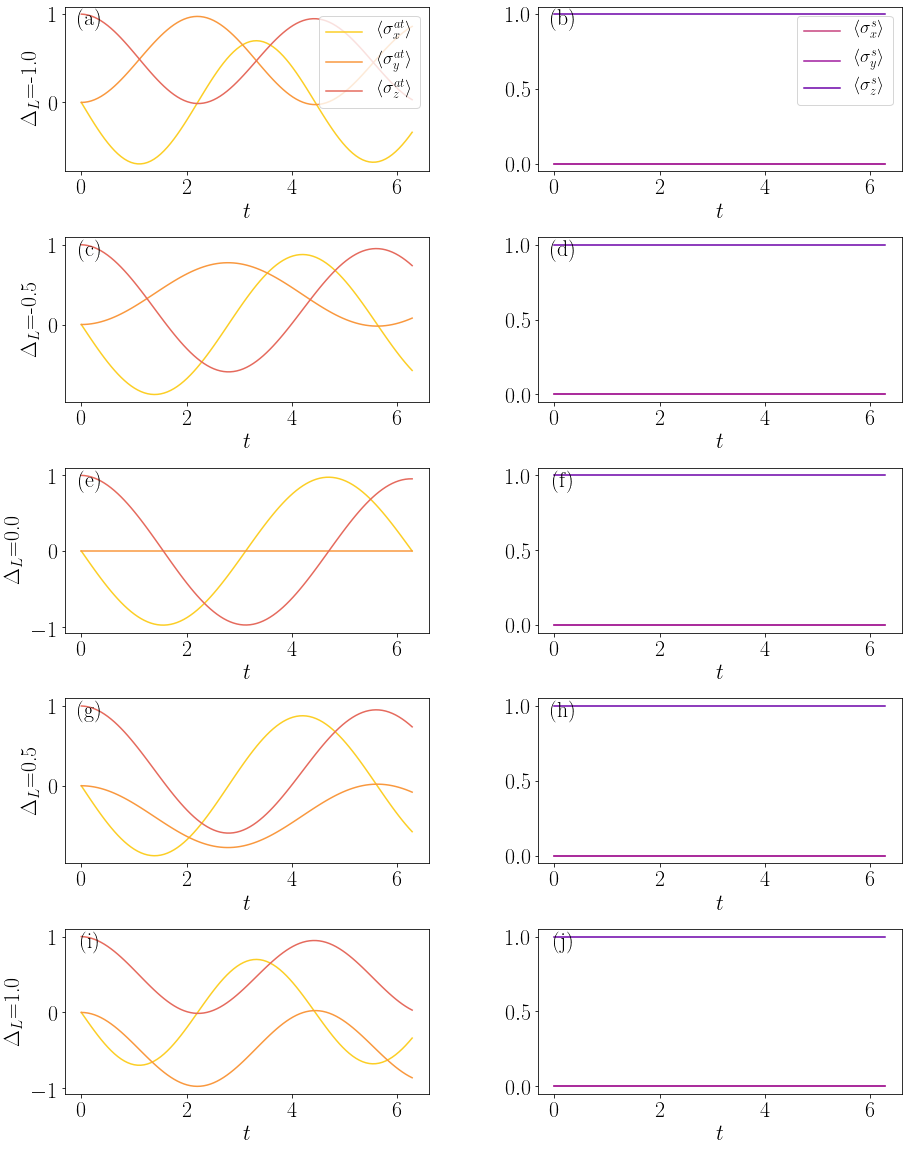

In [254]:
fig, axs = plt.subplots(10, figsize=(15,20))
gs = gridspec.GridSpec(5,2, wspace = 0.3, hspace=0.4)

number_colors = 6
colors1 = plt.cm.plasma(np.linspace(0.9,0.2,number_colors))
#colors2 = plt.cm.plasma(np.linspace(0.8,0.2,number_colors))
  
for i, det in enumerate(detuning_range):

    tab0 = result_eup[det].expect[4]
    tab1 = result_eup[det].expect[5]
    tab2 = result_eup[det].expect[6]
    
    tab3 = result_eup[det].expect[7]
    tab4 = result_eup[det].expect[8]
    tab5 = result_eup[det].expect[9]
    
    
    
    axs[2*i].plot(t_range, tab0, color=colors1[0], label = r"$\langle\sigma_x^{at}\rangle$")
    axs[2*i].plot(t_range, tab1, color=colors1[1],label = r"$\langle\sigma_y^{at}\rangle$")
    axs[2*i].plot(t_range, tab2, color=colors1[2],label = r"$\langle\sigma_z^{at}\rangle$")
    axs[2*i].tick_params(axis='x', labelsize=22)
    axs[2*i].tick_params(axis='y', labelsize=22)
    axs[2*i].set_xlabel('$t$',fontsize = 22)
    axs[2*i].set_position(gs[2*i].get_position(fig))
    axs[2*i].set_ylabel(r'$\Delta_L$='+str(det),fontsize = 22)
    
    axs[2*i+1].plot(t_range, tab3, color=colors1[3], label = r"$\langle\sigma_x^s\rangle$")
    axs[2*i+1].plot(t_range, tab4, color=colors1[4],label = r"$\langle\sigma_y^s\rangle$")
    axs[2*i+1].plot(t_range, tab5, color=colors1[5],label = r"$\langle\sigma_z^s\rangle$")
    axs[2*i+1].tick_params(axis='x', labelsize=22)
    axs[2*i+1].tick_params(axis='y', labelsize=22)
    axs[2*i+1].set_xlabel('$t$',fontsize = 22)
    axs[2*i+1].set_position(gs[2*i+1].get_position(fig))
    
    
        
    if i == 0:
        axs[2*i].legend(loc = 'upper right',fontsize = 18)
        axs[2*i+1].legend(loc = 'upper right',fontsize = 18)
           


axs[0].set_title('(a)', position = (0.07,0.85),fontsize = 22)

axs[1].set_title('(b)', position = (0.07,0.85),fontsize = 22)

axs[2].set_title('(c)', position = (0.07,0.85),fontsize = 22)

axs[3].set_title('(d)', position = (0.07,0.85),fontsize = 22)

axs[4].set_title('(e)', position = (0.07,0.85),fontsize = 22)

axs[5].set_title('(f)', position = (0.07,0.85),fontsize = 22)

axs[6].set_title('(g)', position = (0.07,0.85),fontsize = 22)

axs[7].set_title('(h)', position = (0.07,0.85),fontsize = 22)

axs[8].set_title('(i)', position = (0.07,0.85),fontsize = 22)

axs[9].set_title('(j)', position = (0.07,0.85),fontsize = 22)

plt.show()

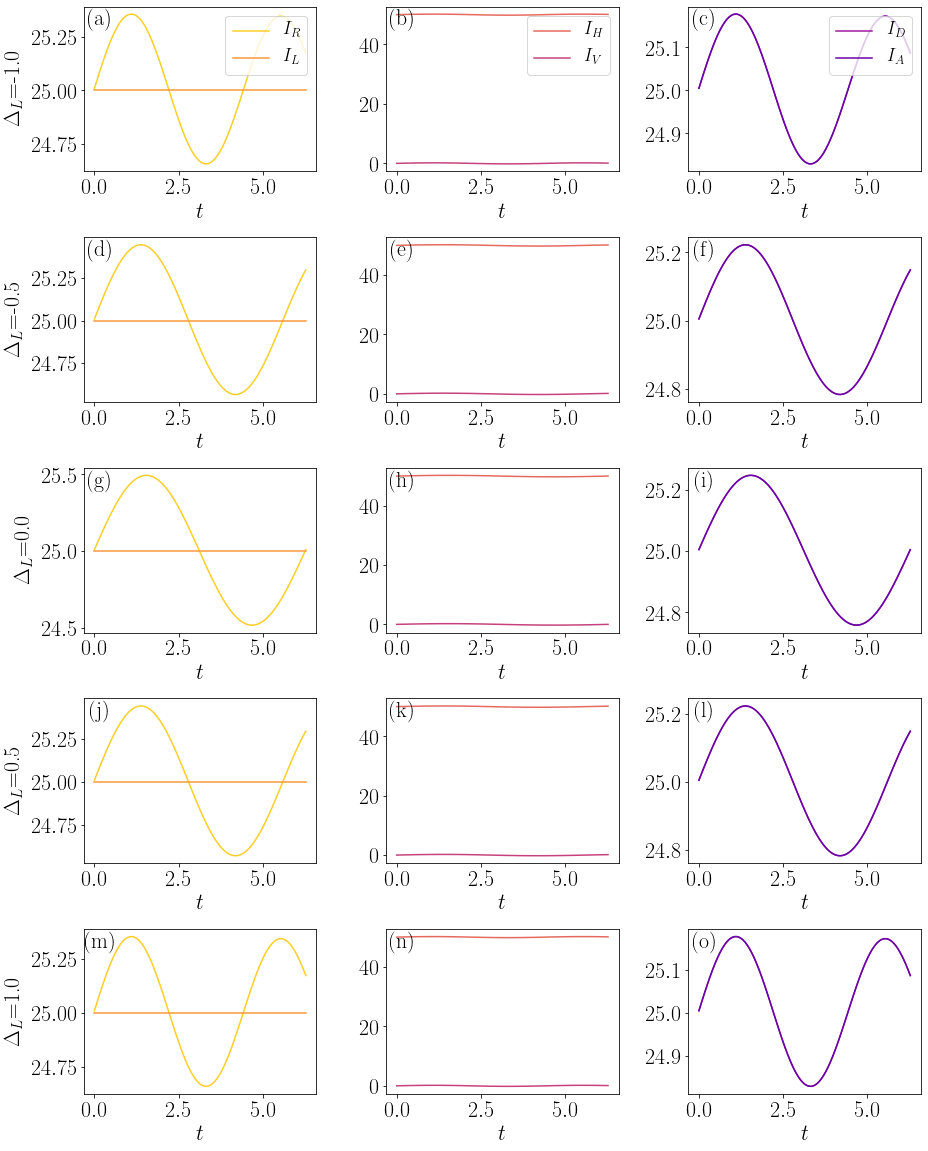

In [255]:
fig, axs = plt.subplots(15, figsize=(15,20))
gs = gridspec.GridSpec(5,3, wspace = 0.3, hspace=0.4)

number_colors = 6
colors1 = plt.cm.plasma(np.linspace(0.9,0.2,number_colors))
#colors2 = plt.cm.plasma(np.linspace(0.8,0.2,number_colors))
  
for i, det in enumerate(detuning_range):

    tab0 = I_R_eup[det]
    tab1 = I_L_eup[det]
    tab2 = I_H_eup[det]
    tab3 = I_V_eup[det]
    tab4 = I_D_eup[det]
    tab5 = I_A_eup[det]
    
    axs[3*i].plot(t_range, tab0, color=colors1[0], label = r"$I_R$")
    axs[3*i].plot(t_range, tab1, color=colors1[1],label = r"$I_L$")
    axs[3*i].tick_params(axis='x', labelsize=22)
    axs[3*i].tick_params(axis='y', labelsize=22)
    axs[3*i].set_xlabel('$t$',fontsize = 22)
    axs[3*i].set_position(gs[3*i].get_position(fig))
    axs[3*i].set_ylabel(r'$\Delta_L$='+str(det),fontsize = 22)
    
    
    axs[3*i+1].plot(t_range, tab2, color=colors1[2], label = r"$I_H$")
    axs[3*i+1].plot(t_range, tab3, color=colors1[3], label = r"$I_V$")    
    axs[3*i+1].tick_params(axis='x', labelsize=22)
    axs[3*i+1].tick_params(axis='y', labelsize=22)
    axs[3*i+1].set_xlabel('$t$',fontsize = 22)
    axs[3*i+1].set_position(gs[3*i+1].get_position(fig)) 
   
    axs[3*i+2].plot(t_range, tab4, color=colors1[4], label = r"$I_D$")
    axs[3*i+2].plot(t_range, tab5, color=colors1[5], label = r"$I_A$")    
    axs[3*i+2].tick_params(axis='x', labelsize=22)
    axs[3*i+2].tick_params(axis='y', labelsize=22)
    axs[3*i+2].set_xlabel('$t$',fontsize = 22)
    axs[3*i+2].set_position(gs[3*i+2].get_position(fig)) 
    
    if i == 0:
        axs[3*i].legend(loc = 'upper right',fontsize = 18)
        axs[3*i+1].legend(loc = 'upper right',fontsize = 18)
        axs[3*i+2].legend(loc = 'upper right',fontsize = 18)
    


axs[0].set_title('(a)', position = (0.07,0.85),fontsize = 22)

axs[1].set_title('(b)', position = (0.07,0.85),fontsize = 22)

axs[2].set_title('(c)', position = (0.07,0.85),fontsize = 22)

axs[3].set_title('(d)', position = (0.07,0.85),fontsize = 22)

axs[4].set_title('(e)', position = (0.07,0.85),fontsize = 22)

axs[5].set_title('(f)', position = (0.07,0.85),fontsize = 22)

axs[6].set_title('(g)', position = (0.07,0.85),fontsize = 22)

axs[7].set_title('(h)', position = (0.07,0.85),fontsize = 22)

axs[8].set_title('(i)', position = (0.07,0.85),fontsize = 22)

axs[9].set_title('(j)', position = (0.07,0.85),fontsize = 22)

axs[10].set_title('(k)', position = (0.07,0.85),fontsize = 22)

axs[11].set_title('(l)', position = (0.07,0.85),fontsize = 22)

axs[12].set_title('(m)', position = (0.07,0.85),fontsize = 22)

axs[13].set_title('(n)', position = (0.07,0.85),fontsize = 22)

axs[14].set_title('(o)', position = (0.07,0.85),fontsize = 22)

plt.show()

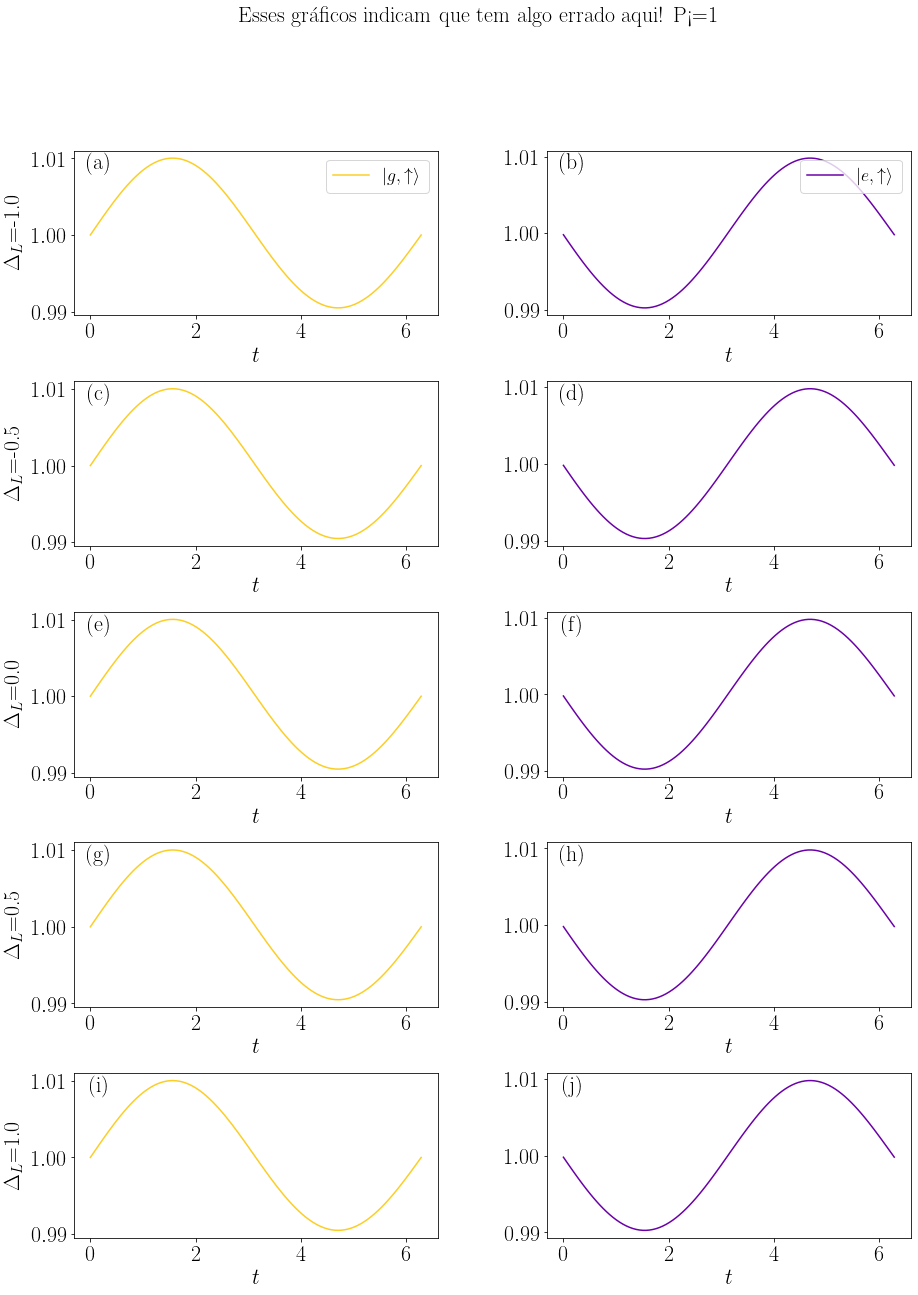

In [260]:
fig, axs = plt.subplots(10, figsize=(15,20))
gs = gridspec.GridSpec(5,2, wspace = 0.3, hspace=0.4)

number_colors = 2
colors1 = plt.cm.plasma(np.linspace(0.9,0.2,number_colors))
#colors2 = plt.cm.plasma(np.linspace(0.8,0.2,number_colors))
  
for i, det in enumerate(detuning_range):

    tab0 = polarization_deg_gup[det]
    tab1 = polarization_deg_eup[det]
    
    
    axs[2*i].plot(t_range, tab0, color=colors1[0], label = r"$|g,\uparrow \rangle$") #, label = r"$\langle\sigma_x^{at}\rangle$")
    axs[2*i].tick_params(axis='x', labelsize=22)
    axs[2*i].tick_params(axis='y', labelsize=22)
    axs[2*i].set_xlabel('$t$',fontsize = 22)
    axs[2*i].set_position(gs[2*i].get_position(fig))
    axs[2*i].set_ylabel(r'$\Delta_L$='+str(det),fontsize = 22)
    
    axs[2*i+1].plot(t_range, tab1, color=colors1[1],label = r"$|e,\uparrow \rangle$")#, label = r"$\langle\sigma_x^s\rangle$")
    axs[2*i+1].tick_params(axis='x', labelsize=22)
    axs[2*i+1].tick_params(axis='y', labelsize=22)
    axs[2*i+1].set_xlabel('$t$',fontsize = 22)
    axs[2*i+1].set_position(gs[2*i+1].get_position(fig))
    
    
        
    if i == 0:
        axs[2*i].legend(loc = 'upper right',fontsize = 18)
        axs[2*i+1].legend(loc = 'upper right',fontsize = 18)
        
           


axs[0].set_title('(a)', position = (0.07,0.85),fontsize = 22)

axs[1].set_title('(b)', position = (0.07,0.85),fontsize = 22)

axs[2].set_title('(c)', position = (0.07,0.85),fontsize = 22)

axs[3].set_title('(d)', position = (0.07,0.85),fontsize = 22)

axs[4].set_title('(e)', position = (0.07,0.85),fontsize = 22)

axs[5].set_title('(f)', position = (0.07,0.85),fontsize = 22)

axs[6].set_title('(g)', position = (0.07,0.85),fontsize = 22)

axs[7].set_title('(h)', position = (0.07,0.85),fontsize = 22)

axs[8].set_title('(i)', position = (0.07,0.85),fontsize = 22)

axs[9].set_title('(j)', position = (0.07,0.85),fontsize = 22)

fig.suptitle('Esses gráficos indicam que tem algo errado aqui! P<=1', fontsize=22)

plt.show()

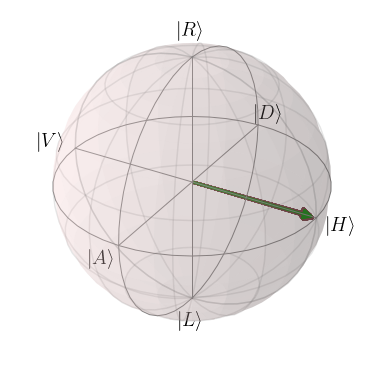

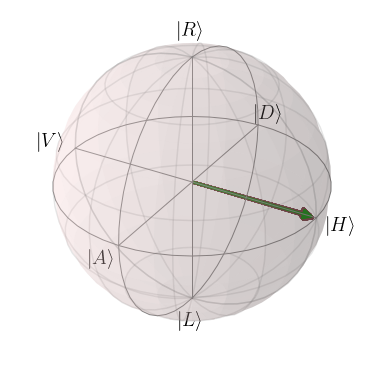

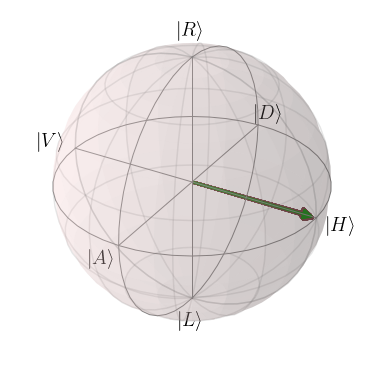

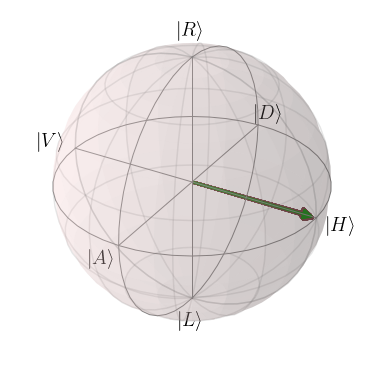

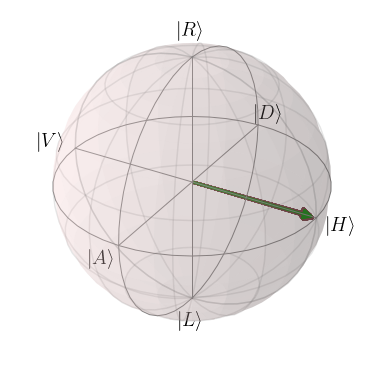

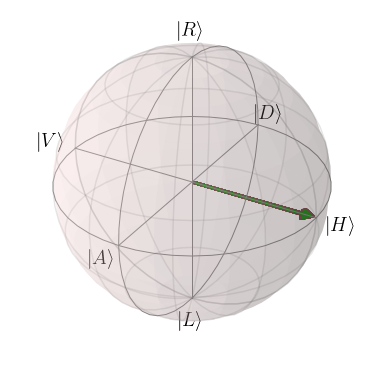

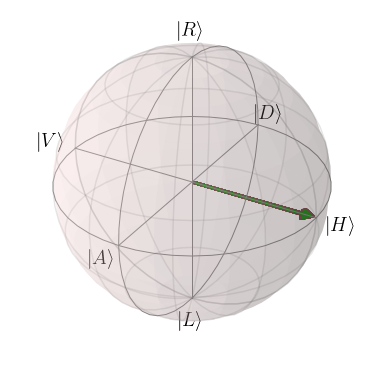

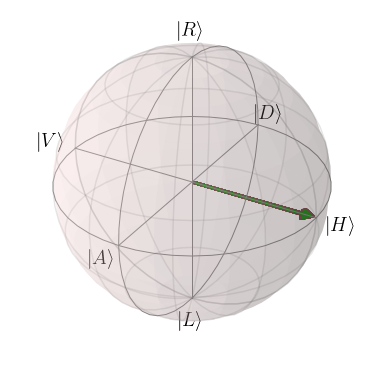

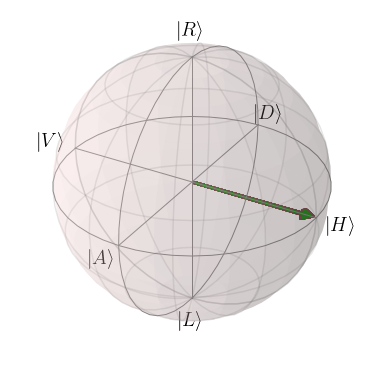

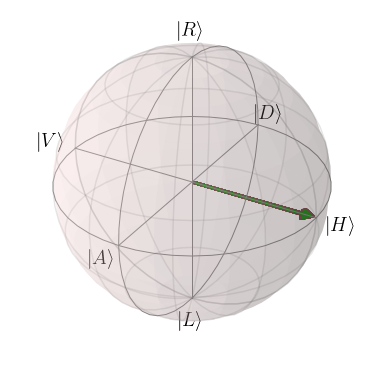

In [259]:
b = dict()
for det in detuning_range:
    b[det] = Bloch()

    #b.view = [-0,-90]
    b[det].xlabel= [r'$\left|A\right>$', r'$\left|D\right>$']
    b[det].ylabel= [r'$\left|H\right>$', r'$\left|V\right>$']
    b[det].zlabel= [r'$\left|R\right>$', r'$\left|L\right>$']
    b[det].add_vectors(poin_vectors_gup[det])
    b[det].show()

b = dict()
for det in detuning_range:
    b[det] = Bloch()

    #b.view = [-0,-90]
    b[det].xlabel= [r'$\left|A\right>$', r'$\left|D\right>$']
    b[det].ylabel= [r'$\left|H\right>$', r'$\left|V\right>$']
    b[det].zlabel= [r'$\left|R\right>$', r'$\left|L\right>$']
    b[det].add_vectors(poin_vectors_eup[det])
    b[det].show()

## Starting from $|g,\uparrow\rangle$ and $|e,\uparrow\rangle$

In [689]:
#################################
#      Parameters
#################################

# Amplitudes - Horizontally polarized
alpha_L = 1/(2*gamma_R**0.5)
alpha_R = 1/(2*gamma_R**0.5)

Omega = 1.

# Pure dephasing - No pure dephasing considered
Gamma_pd_L = 0.0*Omega
Gamma_pd_R = 0.0*Omega

# Dissipation
gamma_L = 0.0*Omega
gamma_R = 0.01*Omega

Omega_R = Omega
Omega_L = 0

# Detunings
Delta_omega_L = 0*Omega_L
Delta_omega_R = 0*Omega_R

detuning_range = np.arange(-Omega, Omega + 0.5, 0.5) # 5 values

# Time range
t_range = np.linspace(0,2*np.pi,101) #time changes from 0 to 2Pi/Omega with steps of Pi/(4 Omega) 
discrete_t_range = np.arange(0,2*np.pi,np.pi*(1/8))

# In the following we'll append the relevant operators depending on the parameters
c_ops = [] 

# Qubit dissipation for each polarization
rate_L = gamma_L
if rate_L > 0.0:
    c_ops.append(np.sqrt(rate_L)*sigma_L)
    
rate_R = gamma_R
if rate_R > 0.0:
    c_ops.append(np.sqrt(rate_R)*sigma_R)

    
# Relevant expectation values list 0-9
expec_list = [sigma_Rd*sigma_R, sigma_Ld*sigma_L,
              
              sigma_R, sigma_L,   
              
              sigma_x_at, sigma_y_at, sigma_z_at,
              
              sigma_x_spin, sigma_y_spin, sigma_z_spin]

# Omega_Rl = ((0.5*Omega)**2 + (0.5*delta_omega_L - 1j*0.25*gamma_L)**2)**0.5
# Omega_Rr = ((0.5*Omega)**2 + (0.5*delta_omega_R - 1j*0.25*gamma_R)**2)**0.5

# sigma_xR = (sigma_Rd + sigma_R)/2
# sigma_yR = (sigma_Rd - sigma_R)/2*1j
# sigma_zR = tensor(ket('0'),ket('0'))*tensor(bra('0'),bra('0'))-tensor(ket('1'),ket('0'))*tensor(bra('1'),bra('0'))

# sigma_xL = (sigma_Ld + sigma_L)/2
# sigma_yL = (sigma_Ld - sigma_L)/2*1j
# sigma_zL = tensor(ket('0'),ket('1'))*tensor(bra('0'),bra('1'))-tensor(ket('1'),ket('1'))*tensor(bra('1'),bra('1'))

#################################
#    Solving the master eqn. 
#################################

#Intial states
Psi_0_vec = [tensor(ket('1'),ket('1')), tensor(ket('1'),ket('0')), # ground state: down[0] and up[1]
             tensor(ket('0'),ket('1')), tensor(ket('0'),ket('0'))] # excited state: down[2] and up[3]

result_gdown = mesolve(H_coh_drive(Delta_omega_L, Delta_omega_R, Omega_L, Omega_R), Psi_0_vec[1], t_range, c_ops, expec_list)
result_edown = mesolve(H_coh_drive(Delta_omega_L, Delta_omega_R, Omega_L, Omega_R), Psi_0_vec[3], t_range, c_ops, expec_list)

#################################
#      The intensities - gup
#################################     

I_R_gup = np.real(gamma_R*result_gup.expect[0] - gamma_R**0.5*(alpha_R*np.conj(result_gup.expect[2]) + alpha_R*result_gup.expect[2])) + np.abs(alpha_R)**2
I_L_gup = np.real(gamma_L*result_gup.expect[1] - gamma_L**0.5*(alpha_L*np.conj(result_gup.expect[3]) + alpha_L*result_gup.expect[3])) + np.abs(alpha_L)**2

bdR_bL_gup = -gamma_L**0.5*alpha_L*np.conj(result_gup.expect[3]) + alpha_L*alpha_R
bdL_bR_gup = -gamma_L**0.5*alpha_L*result_gup.expect[3] + alpha_L*alpha_R

I_H_gup = np.real(0.5*(I_L_gup + I_R_gup + bdR_bL_gup + bdL_bR_gup))
I_V_gup = np.real(0.5*(I_L_gup + I_R_gup - (bdR_bL_gup + bdL_bR_gup)))

I_D_gup = np.real(0.5*(I_L_gup + I_R_gup + 1j*(bdR_bL_gup - bdL_bR_gup)))
I_A_gup = np.real(0.5*(I_L_gup + I_R_gup - 1j*(bdR_bL_gup - bdL_bR_gup)))

#################################
#      The intensities - eup
#################################     

I_R_eup = np.real(gamma_R*result_eup.expect[0] - gamma_R**0.5*(alpha_R*np.conj(result_eup.expect[2]) + alpha_R*result_eup.expect[2])) + np.abs(alpha_R)**2
I_L_eup = np.real(gamma_L*result_eup.expect[1] - gamma_L**0.5*(alpha_L*np.conj(result_eup.expect[3]) + alpha_L*result_eup.expect[3])) + np.abs(alpha_L)**2

bdR_bL_eup = -gamma_L**0.5*alpha_L*np.conj(result_eup.expect[3]) + alpha_L*alpha_R
bdL_bR_eup = -gamma_L**0.5*alpha_L*result_eup.expect[3] + alpha_L*alpha_R

I_H_eup = np.real(0.5*(I_L_eup + I_R_eup + bdR_bL_eup + bdL_bR_eup))
I_V_eup = np.real(0.5*(I_L_eup + I_R_eup - (bdR_bL_eup + bdL_bR_eup)))

I_D_eup = np.real(0.5*(I_L_eup + I_R_eup + 1j*(bdR_bL_eup - bdL_bR_eup)))
I_A_eup = np.real(0.5*(I_L_eup + I_R_eup - 1j*(bdR_bL_eup - bdL_bR_eup)))

######################################
#    Poincaré sphere vectors - gup
######################################

poin_vectors_gup = []

for i in range(0, len(I_L_gup)):
    poin_vectors_gup.append([(I_R_gup[i] - I_L_gup[i])/(I_R_gup[i] + I_L_gup[i]), (I_H_gup[i] - I_V_gup[i])/(I_H_gup[i] + I_V_gup[i]), (I_A_gup[i] - I_D_gup[i])/(I_A_gup[i] + I_D_gup[i])])

polarization_deg_gup = []

for i in range(0, len(poin_vectors_gup)):
    polarization_deg_gup.append((poin_vectors_gup[i][0]**2 + poin_vectors_gup[i][1]**2 + poin_vectors_gup[i][2]**2)**0.5)    
    
######################################
#    Poincaré sphere vectors - eup
######################################

poin_vectors_eup = []

for i in range(0, len(I_L_eup)):
    poin_vectors_eup.append([(I_R_eup[i] - I_L_eup[i])/(I_R_eup[i] + I_L_eup[i]), (I_H_eup[i] - I_V_eup[i])/(I_H_eup[i] + I_V_eup[i]), (I_A_eup[i] - I_D_eup[i])/(I_A_eup[i] + I_D_eup[i])])

polarization_deg_eup = []

for i in range(0, len(poin_vectors_eup)):
    polarization_deg_eup.append((poin_vectors_eup[i][0]**2 + poin_vectors_eup[i][1]**2 + poin_vectors_eup[i][2]**2)**0.5)     

In [214]:
######################################
#    Poincaré sphere vectors - gup
######################################
poin_vectors_gup = dict()
polarization_deg_gup = dict()

poin_vectors_eup = dict()
polarization_deg_eup = dict()

for k in detuning_range:
    poin_vectors_gup[k] = []
    polarization_deg_gup[k] = []

    poin_vectors_eup[k] = []
    polarization_deg_eup[k] = []

    for i in range(0, len(I_L_gup[k])):
        poin_vectors_gup[k].append([(I_A_gup[k][i] - I_D_gup[k][i])/(I_A_gup[k][i] + I_D_gup[k][i]) ,(I_H_gup[k][i] - I_V_gup[k][i])/(I_H_gup[k][i] + I_V_gup[k][i]),(I_R_gup[k][i] - I_L_gup[k][i])/(I_R_gup[k][i] + I_L_gup[k][i])])


    for i in range(0, len(poin_vectors_gup[k])):
        polarization_deg_gup[k].append((poin_vectors_gup[k][i][0]**2 + poin_vectors_gup[k][i][1]**2 + poin_vectors_gup[k][i][2]**2)**0.5)    

    for i in range(0, len(I_L_eup[k])):
        poin_vectors_eup[k].append([(I_R_eup[k][i] - I_L_eup[k][i])/(I_R_eup[k][i] + I_L_eup[k][i]), (I_H_eup[k][i] - I_V_eup[k][i])/(I_H_eup[k][i] + I_V_eup[k][i]), (I_A_eup[k][i] - I_D_eup[k][i])/(I_A_eup[k][i] + I_D_eup[k][i])])

    for i in range(0, len(poin_vectors_eup[k])):
        polarization_deg_eup[k].append((poin_vectors_eup[k][i][0]**2 + poin_vectors_eup[k][i][1]**2 + poin_vectors_eup[k][i][2]**2)**0.5)    

In [714]:
states = []

thetas = linspace(0,pi,21)

for theta in thetas:

    states.append((cos(theta/2)*basis(2,0) + sin(theta/2)*basis(2,1)).unit())


animate_bloch(poin_vectors_gdown, duration=0.1, save_all=False)

TypeError: Arguments must be quantum objects or eseries

In [ ]:
# result_gup = mesolve(H_coh_drive(Delta_omega_L, Delta_omega_R, Omega_L, Omega_R), Psi_0_vec[1], discrete_t_range, c_ops, expec_list)

# result_edown = mesolve(H_coh_drive(Delta_omega_L, Delta_omega_R, Omega_L, Omega_R), Psi_0_vec[2], discrete_t_range, c_ops, expec_list)
# result_eup = mesolve(H_coh_drive(Delta_omega_L, Delta_omega_R, Omega_L, Omega_R), Psi_0_vec[3], discrete_t_range, c_ops, expec_list)

In [ ]:
#################################
#      The intensities - gup
#################################     

# I_L_gup = np.real(gamma_L*result_gup.expect[1] - gamma_L**0.5*(alpha_L*np.conj(result_gup.expect[3]) + alpha_L*result_gup.expect[3])) + np.abs(alpha_L)**2
# I_R_gup = np.real(gamma_R*result_gup.expect[0] - gamma_R**0.5*(alpha_R*np.conj(result_gup.expect[2]) + alpha_R*result_gup.expect[2])) + np.abs(alpha_R)**2

# bdR_bL_gup = -gamma_L**0.5*alpha_L*np.conj(result_gup.expect[3]) + alpha_L*alpha_R
# bdL_bR_gup = -gamma_L**0.5*alpha_L*result_gup.expect[3] + alpha_L*alpha_R

# I_H_gup = np.real(0.5*(I_L_gup + I_R_gup + bdR_bL_gup + bdL_bR_gup))
# I_V_gup = np.real(0.5*(I_L_gup + I_R_gup - (bdR_bL_gup + bdL_bR_gup)))

# I_D_gup = np.real(0.5*(I_L_gup + I_R_gup + 1j*(bdR_bL_gup - bdL_bR_gup)))
# I_A_gup = np.real(0.5*(I_L_gup + I_R_gup - 1j*(bdR_bL_gup - bdL_bR_gup)))

# #################################
# #      The intensities - edown
# #################################     

# I_L_edown = np.real(gamma_L*result_edown.expect[1] - gamma_L**0.5*(alpha_L*np.conj(result_edown.expect[3]) + alpha_L*result_edown.expect[3])) + np.abs(alpha_L)**2
# I_R_edown = np.real(gamma_R*result_edown.expect[0] - gamma_R**0.5*(alpha_R*np.conj(result_edown.expect[2]) + alpha_R*result_edown.expect[2])) + np.abs(alpha_R)**2

# bdR_bL_edown = -gamma_L**0.5*alpha_L*np.conj(result_edown.expect[3]) + alpha_L*alpha_R
# bdL_bR_edown = -gamma_L**0.5*alpha_L*result_edown.expect[3] + alpha_L*alpha_R

# I_H_edown = np.real(0.5*(I_L_edown + I_R_edown + bdR_bL_edown + bdL_bR_edown))
# I_V_edown = np.real(0.5*(I_L_edown + I_R_edown - (bdR_bL_edown + bdL_bR_edown)))

# I_D_edown = np.real(0.5*(I_L_edown + I_R_edown + 1j*(bdR_bL_edown - bdL_bR_edown)))
# I_A_edown = np.real(0.5*(I_L_edown + I_R_edown - 1j*(bdR_bL_edown - bdL_bR_edown)))

# #################################
# #      The intensities - eup
# #################################     

# I_L_eup = np.real(gamma_L*result_eup.expect[1] - gamma_L**0.5*(alpha_L*np.conj(result_eup.expect[3]) + alpha_L*result_eup.expect[3])) + np.abs(alpha_L)**2
# I_R_eup = np.real(gamma_R*result_eup.expect[0] - gamma_R**0.5*(alpha_R*np.conj(result_eup.expect[2]) + alpha_R*result_eup.expect[2])) + np.abs(alpha_R)**2

# bdR_bL_eup = -gamma_L**0.5*alpha_L*np.conj(result_eup.expect[3]) + alpha_L*alpha_R
# bdL_bR_eup = -gamma_L**0.5*alpha_L*result_eup.expect[3] + alpha_L*alpha_R

# I_H_eup = np.real(0.5*(I_L_eup + I_R_eup + bdR_bL_eup + bdL_bR_eup))
# I_V_eup = np.real(0.5*(I_L_eup + I_R_eup - (bdR_bL_eup + bdL_bR_eup)))

# I_D_eup = np.real(0.5*(I_L_eup + I_R_eup + 1j*(bdR_bL_eup - bdL_bR_eup)))
# I_A_eup = np.real(0.5*(I_L_eup + I_R_eup - 1j*(bdR_bL_eup - bdL_bR_eup)))

In [ ]:
# poin_vectors_gup = []

# for i in range(0, len(I_L)):
#     poin_vectors_gup.append([(I_R_gup[i] - I_L_gup[i])/(I_R_gup[i] + I_L_gup[i]), (I_H_gup[i] - I_V_gup[i])/(I_H_gup[i] + I_V_gup[i]), (I_A_gup[i] - I_D_gup[i])/(I_A_gup[i] + I_D_gup[i])])

# polarization_deg_gup = []

# for i in range(0, len(poin_vectors_gup)):
#     polarization_deg_gup.append((poin_vectors_gup[i][0]**2 + poin_vectors_gup[i][1]**2 + poin_vectors_gup[i][2]**2)**0.5)


# poin_vectors_edown = []

# for i in range(0, len(I_L)):
#     poin_vectors_edown.append([(I_R_edown[i] - I_L_edown[i])/(I_R_edown[i] + I_L_edown[i]), (I_H_edown[i] - I_V_edown[i])/(I_H_edown[i] + I_V_edown[i]), (I_A_edown[i] - I_D_edown[i])/(I_A_edown[i] + I_D_edown[i])])

# polarization_deg_edown = []

# for i in range(0, len(poin_vectors_edown)):
#     polarization_deg_edown.append((poin_vectors_edown[i][0]**2 + poin_vectors_edown[i][1]**2 + poin_vectors_edown[i][2]**2)**0.5)

    
# poin_vectors_eup = []

# for i in range(0, len(I_L)):
#     poin_vectors_eup.append([(I_R_eup[i] - I_L_eup[i])/(I_R_eup[i] + I_L_eup[i]), (I_H_eup[i] - I_V_eup[i])/(I_H_eup[i] + I_V_eup[i]), (I_A_eup[i] - I_D_eup[i])/(I_A_eup[i] + I_D_eup[i])])

# polarization_deg_eup = []

# for i in range(0, len(poin_vectors_eup)):
#     polarization_deg_eup.append((poin_vectors_eup[i][0]**2 + poin_vectors_eup[i][1]**2 + poin_vectors_eup[i][2]**2)**0.5)

In [13]:
# Analytical solution

#Defining the coefficients
def f0Lg(t):
    function = (np.e**(-0.25*gamma*t)*(4*Omega_Rl*np.cos(Omega_Rl*t)+(gamma_L + 1j*2*delta_omega_L)*np.sin(Omega_Rl*t)))/(4*Omega_Rl)
    return function

def f0Le(t):
    function = (np.e**(-0.25*gamma_L*t)*Omega*np.sin(Omega_Rl*t))/(2*Omega_Rl)
    return function

def f1Lg(t,tau): #tau is the integration variable
    f = gamma_L**0.5*((np.e**(-0.25*gamma_L*t)*Omega)/(8*Omega_Rl**2))*np.sin(Omega_Rl*tau)*(4*Omega_Rl*np.cos(Omega_Rl*(t-tau))+(gamma_L+1j*2*delta_omega_L*np.sin(Omega_Rl*(t-tau))))
    return f

def f1Le(t,tau): #tau is the integration variable
    f = gamma_L**0.5*np.e**(-0.25*gamma_L*t)*(Omega/(2*Omega_Rl))**2*np.sin(Omega_Rl*(t-tau))*np.sin(Omega_Rl*tau)
    return f

def f0Rg(t):
    function = (np.e**(-0.25*gamma_R*t)*(4*Omega_Rr*np.cos(Omega_Rr*t)+(gamma_R + 1j*2*delta_omega_R)*np.sin(Omega_Rr*t)))/(4*Omega_Rr)
    return function

def f0Re(t):
    function = (np.e**(-0.25*gamma_R*t)*Omega*np.sin(Omega_Rr*t))/(2*Omega_Rr)
    return function

def f1Rg(t,tau): #tau is the integration variable
    f = gamma_R**0.5*((np.e**(-0.25*gamma_R*t)*Omega)/(8*Omega_Rr**2))*np.sin(Omega_Rr*tau)*(4*Omega_Rr*np.cos(Omega_Rr*(t-tau))+(gamma_R+1j*2*delta_omega_R*np.sin(Omega_Rr*(t-tau))))
    return f

def f1Re(t,tau): #tau is the integration variable
    f = gamma_R**0.5*np.e**(-0.25*gamma_R*t)*(Omega/(2*Omega_Rr))**2*np.sin(Omega_Rr*(t-tau))*np.sin(Omega_Rr*tau)
    return f

def P_e_coh_d_spin(t):
    Int = integrate.quad(lambda tau: np.abs(f1Le(t,tau)*f1Re(t,tau))**2,0,t)
    pe = np.abs(f0Le(t)+f0Re(t))**2  + Int[0] #I have to use [0] because this is the value of the integral [1] is the error of the numerical computation (see doc. https://docs.scipy.org/doc/scipy/reference/tutorial/integrate.html)
    return pe

def mean_sigma_L(t):
    Int2 = integrate.quad(lambda tau: f1Le(t,tau)*f1Lg(t,tau),0,t)
    #Int3 = integrate.quad(lambda tau: f1Le(t,tau)*f1Lg(t,tau),0,t)
    return np.real((f0Lg(t)*f0Le(t) + Int2[0]))
    

In [15]:
# discrete_cohL = []
# discrete_Pe = []

# for i in discrete_t_range:
#     np.array([discrete_Pe.append(P_e_coh_d_spin(i))])
#     np.array([discrete_cohL.append(mean_sigma_L(i))])

NameError: name 'discrete_Pe' is not defined

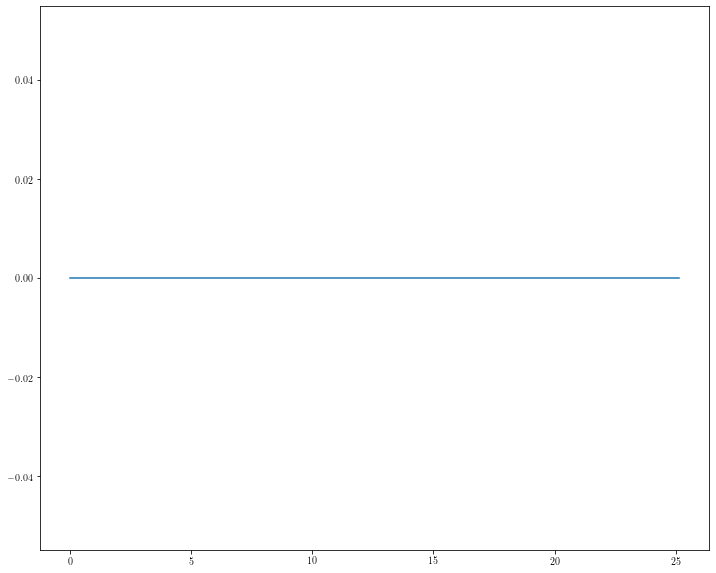

In [9]:
P_exc = result.expect[0]
P_ex_num = result.expect[2] + result.expect[3]
#CohL = result.expect[2]

fig, axs = plt.subplots(1,1, figsize = (12,10))

plt.rc('text', usetex=True)
plt.rc('font', family='serif')

axs.plot(t_range, P_exc,  label = r"$\Re\{\langle \sigma_L \rangle \}$ numerical")
axs.plot(discrete_t_range, discrete_Pe, 'o', label = r"$P_e$ analytical")
#axs.plot(t_range, P_ex_num, label = r"$P_g=\langle \sigma \sigma^\dagger \rangle$")
#axs.plot(t_range, np.real(CohL), label = r"$\Re\{\langle \sigma \rangle \}$ numerical")
#axs.plot(discrete_t_range, discrete_cohL, 'o', label = r"$\Re\{\langle \sigma_L \rangle \}$ analytical")
axs.legend(fontsize = 22)
axs.tick_params(axis='x', labelsize=22)#These lines set the font size of the xy labels
axs.tick_params(axis='y', labelsize=22)
axs.set_xlabel(r'$t$', size = 22)
#axs.set_ylabel(r'$\langle\sigma^\dagger \sigma\rangle$', size = 22)
axs.set_title('Comparison CM vs. numerical solution', size = 22)

plt.savefig('Comparison-num-vs-analy-Res-Cohe-drive-spin-sigma_L.png',bbox_inches='tight') #Save sempre antes do show!
plt.show()

In [ ]:
mean_sigmaxat = result.expect[4]
mean_sigmayat = result.expect[5]
mean_sigmazat = result.expect[6]


fig, axs = plt.subplots(1,1, figsize = (12,10))

plt.rc('text', usetex=True)
plt.rc('font', family='serif')

axs.plot(t_range, mean_sigmaxat,  label = r"$\langle\sigma_x^{at}\rangle$")
axs.plot(t_range, mean_sigmayat,  label = r"$\langle\sigma_y^{at}\rangle$")
axs.plot(t_range, mean_sigmazat,  label = r"$\langle\sigma_z^{at}\rangle$")
#axs.plot(discrete_t_range, discrete_PeSE, 'o', label = r"$P_e$ analytical")
#axs.plot(t_range, P_gs, label = r"$P_g=\langle \sigma \sigma^\dagger \rangle$")
#axs.plot(t_range, np.real(Coh), label = r"$\Re\{\langle \sigma \rangle \}$ numerical")
#axs.plot(discrete_t_range, discrete_cohSE, 'o', label = r"$\Re\{\langle \sigma \rangle \}$ analytical")
axs.legend(fontsize = 22)
axs.tick_params(axis='x', labelsize=22)#These lines set the font size of the xy labels
axs.tick_params(axis='y', labelsize=22)
axs.set_xlabel(r'$t$', size = 22)
#axs.set_ylabel(r'$\langle\sigma^\dagger \sigma\rangle$', size = 22)
#axs.set_title('Comparison CM vs. numerical solution', size = 22)

plt.savefig('Mean_atomic_pauli_ops_coh_drive_spin.png',bbox_inches='tight') #Save sempre antes do show!
plt.show()

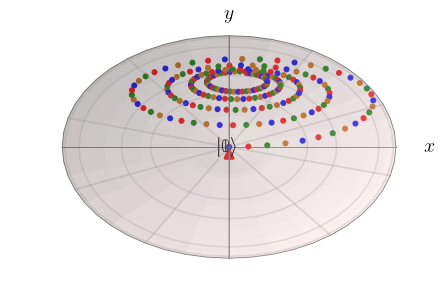

<Figure size 360x360 with 0 Axes>

In [52]:
xx = mean_sigmaxat
yy = mean_sigmayat
zz = mean_sigmazat

fig = figure()
ax = Axes3D(fig,azim = 180, elev = -270)
sphere = Bloch(axes = ax)

def animate(i):
     sphere.clear()
     sphere.add_vectors([0,0,-1])
     sphere.add_points([mean_sigmaxat.tolist()[0:i+1],mean_sigmayat.tolist()[0:i+1],mean_sigmazat.tolist()[0:i+1]],'m')
     sphere.make_sphere()
     return ax

def init():
     sphere.vector_color = ['r']
     return ax

ani = animation.FuncAnimation(fig, animate, len(mean_sigmaxat), init_func=init,repeat=False)
ani.save('blochXY-coh-drive-spin-at.gif',writer='PillowWriter',fps = 21)
plt.show()

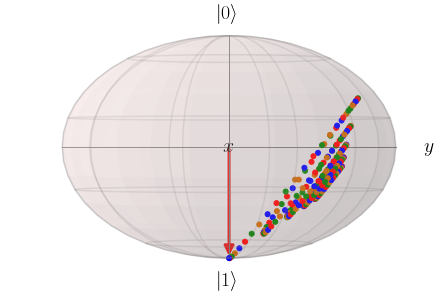

<Figure size 360x360 with 0 Axes>

In [53]:
fig = figure()
ax = Axes3D(fig,azim = -90, elev = 0)
sphere = Bloch(axes = ax)

def animate(i):
     sphere.clear()
     sphere.add_vectors([0,0,-1])
     sphere.add_points([mean_sigmaxat.tolist()[0:i+1],mean_sigmayat.tolist()[0:i+1],mean_sigmazat.tolist()[0:i+1]],'m')
     sphere.make_sphere()
     return ax

def init():
     sphere.vector_color = ['r']
     return ax

ani = animation.FuncAnimation(fig, animate, len(mean_sigmaxat), init_func=init,repeat=False)
ani.save('blochZ-coh-drive-spin-at.gif',writer='PillowWriter',fps = 21)
plt.show()

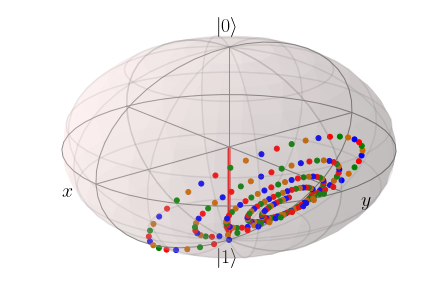

<Figure size 360x360 with 0 Axes>

In [54]:
fig = figure()
ax = Axes3D(fig,azim = -40, elev = 30)
sphere = Bloch(axes = ax)

def animate(i):
     sphere.clear()
     sphere.add_vectors([0,0,-1])
     sphere.add_points([mean_sigmaxat.tolist()[0:i+1],mean_sigmayat.tolist()[0:i+1],mean_sigmazat.tolist()[0:i+1]],'m')
     sphere.make_sphere()
     return ax

def init():
     sphere.vector_color = ['r']
     return ax

ani = animation.FuncAnimation(fig, animate, len(mean_sigmaxat), init_func=init,repeat=False)
ani.save('blochXYZ-coh-drive-spin-at.gif',writer='PillowWriter',fps = 21)
plt.show()

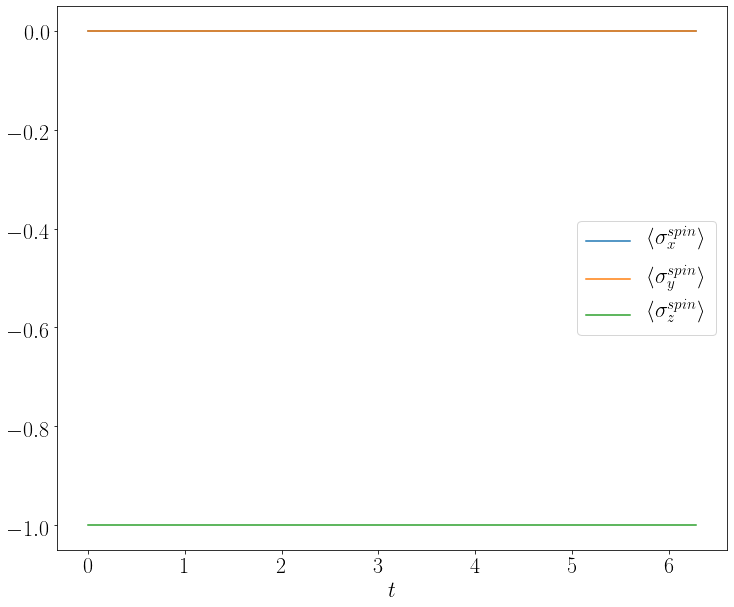

In [318]:
mean_sigmax_spin = result.expect[7]
mean_sigmay_spin = result.expect[8]
mean_sigmaz_spin = result.expect[9]


fig, axs = plt.subplots(1,1, figsize = (12,10))

plt.rc('text', usetex=True)
plt.rc('font', family='serif')

axs.plot(t_range, mean_sigmax_spin,  label = r"$\langle\sigma_x^{spin}\rangle$")
axs.plot(t_range, mean_sigmay_spin,  label = r"$\langle\sigma_y^{spin}\rangle$")
axs.plot(t_range, mean_sigmaz_spin,  label = r"$\langle\sigma_z^{spin}\rangle$")
#axs.plot(discrete_t_range, discrete_PeSE, 'o', label = r"$P_e$ analytical")
#axs.plot(t_range, P_gs, label = r"$P_g=\langle \sigma \sigma^\dagger \rangle$")
#axs.plot(t_range, np.real(Coh), label = r"$\Re\{\langle \sigma \rangle \}$ numerical")
#axs.plot(discrete_t_range, discrete_cohSE, 'o', label = r"$\Re\{\langle \sigma \rangle \}$ analytical")
axs.legend(fontsize = 22)
axs.tick_params(axis='x', labelsize=22)#These lines set the font size of the xy labels
axs.tick_params(axis='y', labelsize=22)
axs.set_xlabel(r'$t$', size = 22)
#axs.set_ylabel(r'$\langle\sigma^\dagger \sigma\rangle$', size = 22)
#axs.set_title('Comparison CM vs. numerical solution', size = 22)

plt.savefig('Mean_spintronic_pauli_ops_coh_drive_spin.png',bbox_inches='tight') #Save sempre antes do show!
plt.show()

In [485]:
from qutip.ipynbtools import version_table

version_table()